In [2]:
!nvidia-smi

Wed Apr 21 13:52:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:5E:00.0 Off |                    0 |
| N/A   33C    P0    25W / 250W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [3]:
import numpy as np
import h5py
import unet_uae_filter_16_32_32_64 as vae_util
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.optimizers import Adam
import tensorflow as tf 
# tf.config.gpu.set_per_process_memory_fraction(0.75)
# tf.config.gpu.set_per_process_memory_growth(True)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.9
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [4]:
def load_data(data_path, array_name_list):
    hf_r = h5py.File(data_path, 'r')
    result = []
    for name in array_name_list:
        result.append(np.array(hf_r.get(name)))
    hf_r.close()
    return result

In [5]:
data_dir = './data'
# load training data
data_path = os.path.join(data_dir, '2998reals_ccs_data_xyz_20_20_5')
sat_t, logk, p_t, ground_disp_t = load_data(data_path, ['sat', 'logk', 'p', 'ground_disp'])
# sat_t = np.delete(sat_t, 1251, axis = 0) # index 1251 should be removed as an outlier
# logk = np.delete(logk, 1251, axis = 0)
# load eval data
print('sw_t shape is ', sat_t.shape)
print('logk shape is ', logk.shape)
print('p_t shape is ', p_t.shape)
print('ground_disp shape is ', ground_disp_t.shape)

sw_t shape is  (2998, 11, 12, 40, 40)
logk shape is  (2998, 12, 40, 40)
p_t shape is  (2998, 11, 12, 40, 40)
ground_disp shape is  (2998, 11, 41, 41)


In [6]:
sat_t[sat_t < 0.01] = 0.01
sat_t[sat_t > 0.88] = 0.88

In [7]:
depth = 10
nr = logk.shape[0]
train_nr = 2000
test_nr = 500

In [8]:
#step_index = [1, 2, 3, 6, 8, 10, 12, 14, 17, 20]
step_index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
train_x = logk[:train_nr, ...]
train_y = sat_t[:train_nr, step_index, :, :, :]

test_x = logk[nr-test_nr:, ...]
test_y = sat_t[nr-test_nr:, step_index, :, :, :]

train_x = train_x[:, :, :, :, None]
train_y = train_y[:, :, :, :, :, None]
test_x = test_x[:, :, :, :, None]
test_y = test_y[:, :, :, :, :, None]
print('train_x shape is ', train_x.shape)
print('train_y shape is ', train_y.shape)
print('test_x shape is ', test_x.shape)
print('test_y shape is ', test_y.shape)

train_x shape is  (2000, 12, 40, 40, 1)
train_y shape is  (2000, 10, 12, 40, 40, 1)
test_x shape is  (500, 12, 40, 40, 1)
test_y shape is  (500, 10, 12, 40, 40, 1)


In [9]:
input_shape=(12, 40, 40, 1)
depth = 10
vae_model,_ = vae_util.create_vae(input_shape, depth)
#vae_model.summary(line_length=150)

In [10]:
output_dir = 'saved_models/'
vae_model.load_weights(output_dir + 'saved-model-10-steps-lr3e-4-saturation-hd-0-filter_16_32_32_64-mse-300-22.81.h5')

In [11]:
pred_list = []
test_batch_size = 10 
batch_num = int(round(test_nr / test_batch_size))
for i in range(batch_num):
    next_batch_idx = min((i+1)*test_batch_size, test_x.shape[0])
    pred_list.append(vae_model.predict(test_x[i*test_batch_size: next_batch_idx, ...]))

pred = np.concatenate(pred_list, axis = 0)
print(pred.shape)

(500, 10, 12, 40, 40, 1)


In [12]:
sat_pred = pred[:, :, :, :, :, 0]
sat_true = test_y[:, :, :, :, :, 0]
print('sat_pred shape is ', sat_pred.shape)
print('sat_true shape is ', sat_true.shape)

sat_pred shape is  (500, 10, 12, 40, 40)
sat_true shape is  (500, 10, 12, 40, 40)


In [13]:
print('sat min ', sat_pred.min())
print('sat max ', sat_pred.max())

sat min  -0.09823716
sat max  0.8677342


In [14]:
sat_pred.shape

(500, 10, 12, 40, 40)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('jet')

<Figure size 432x288 with 0 Axes>

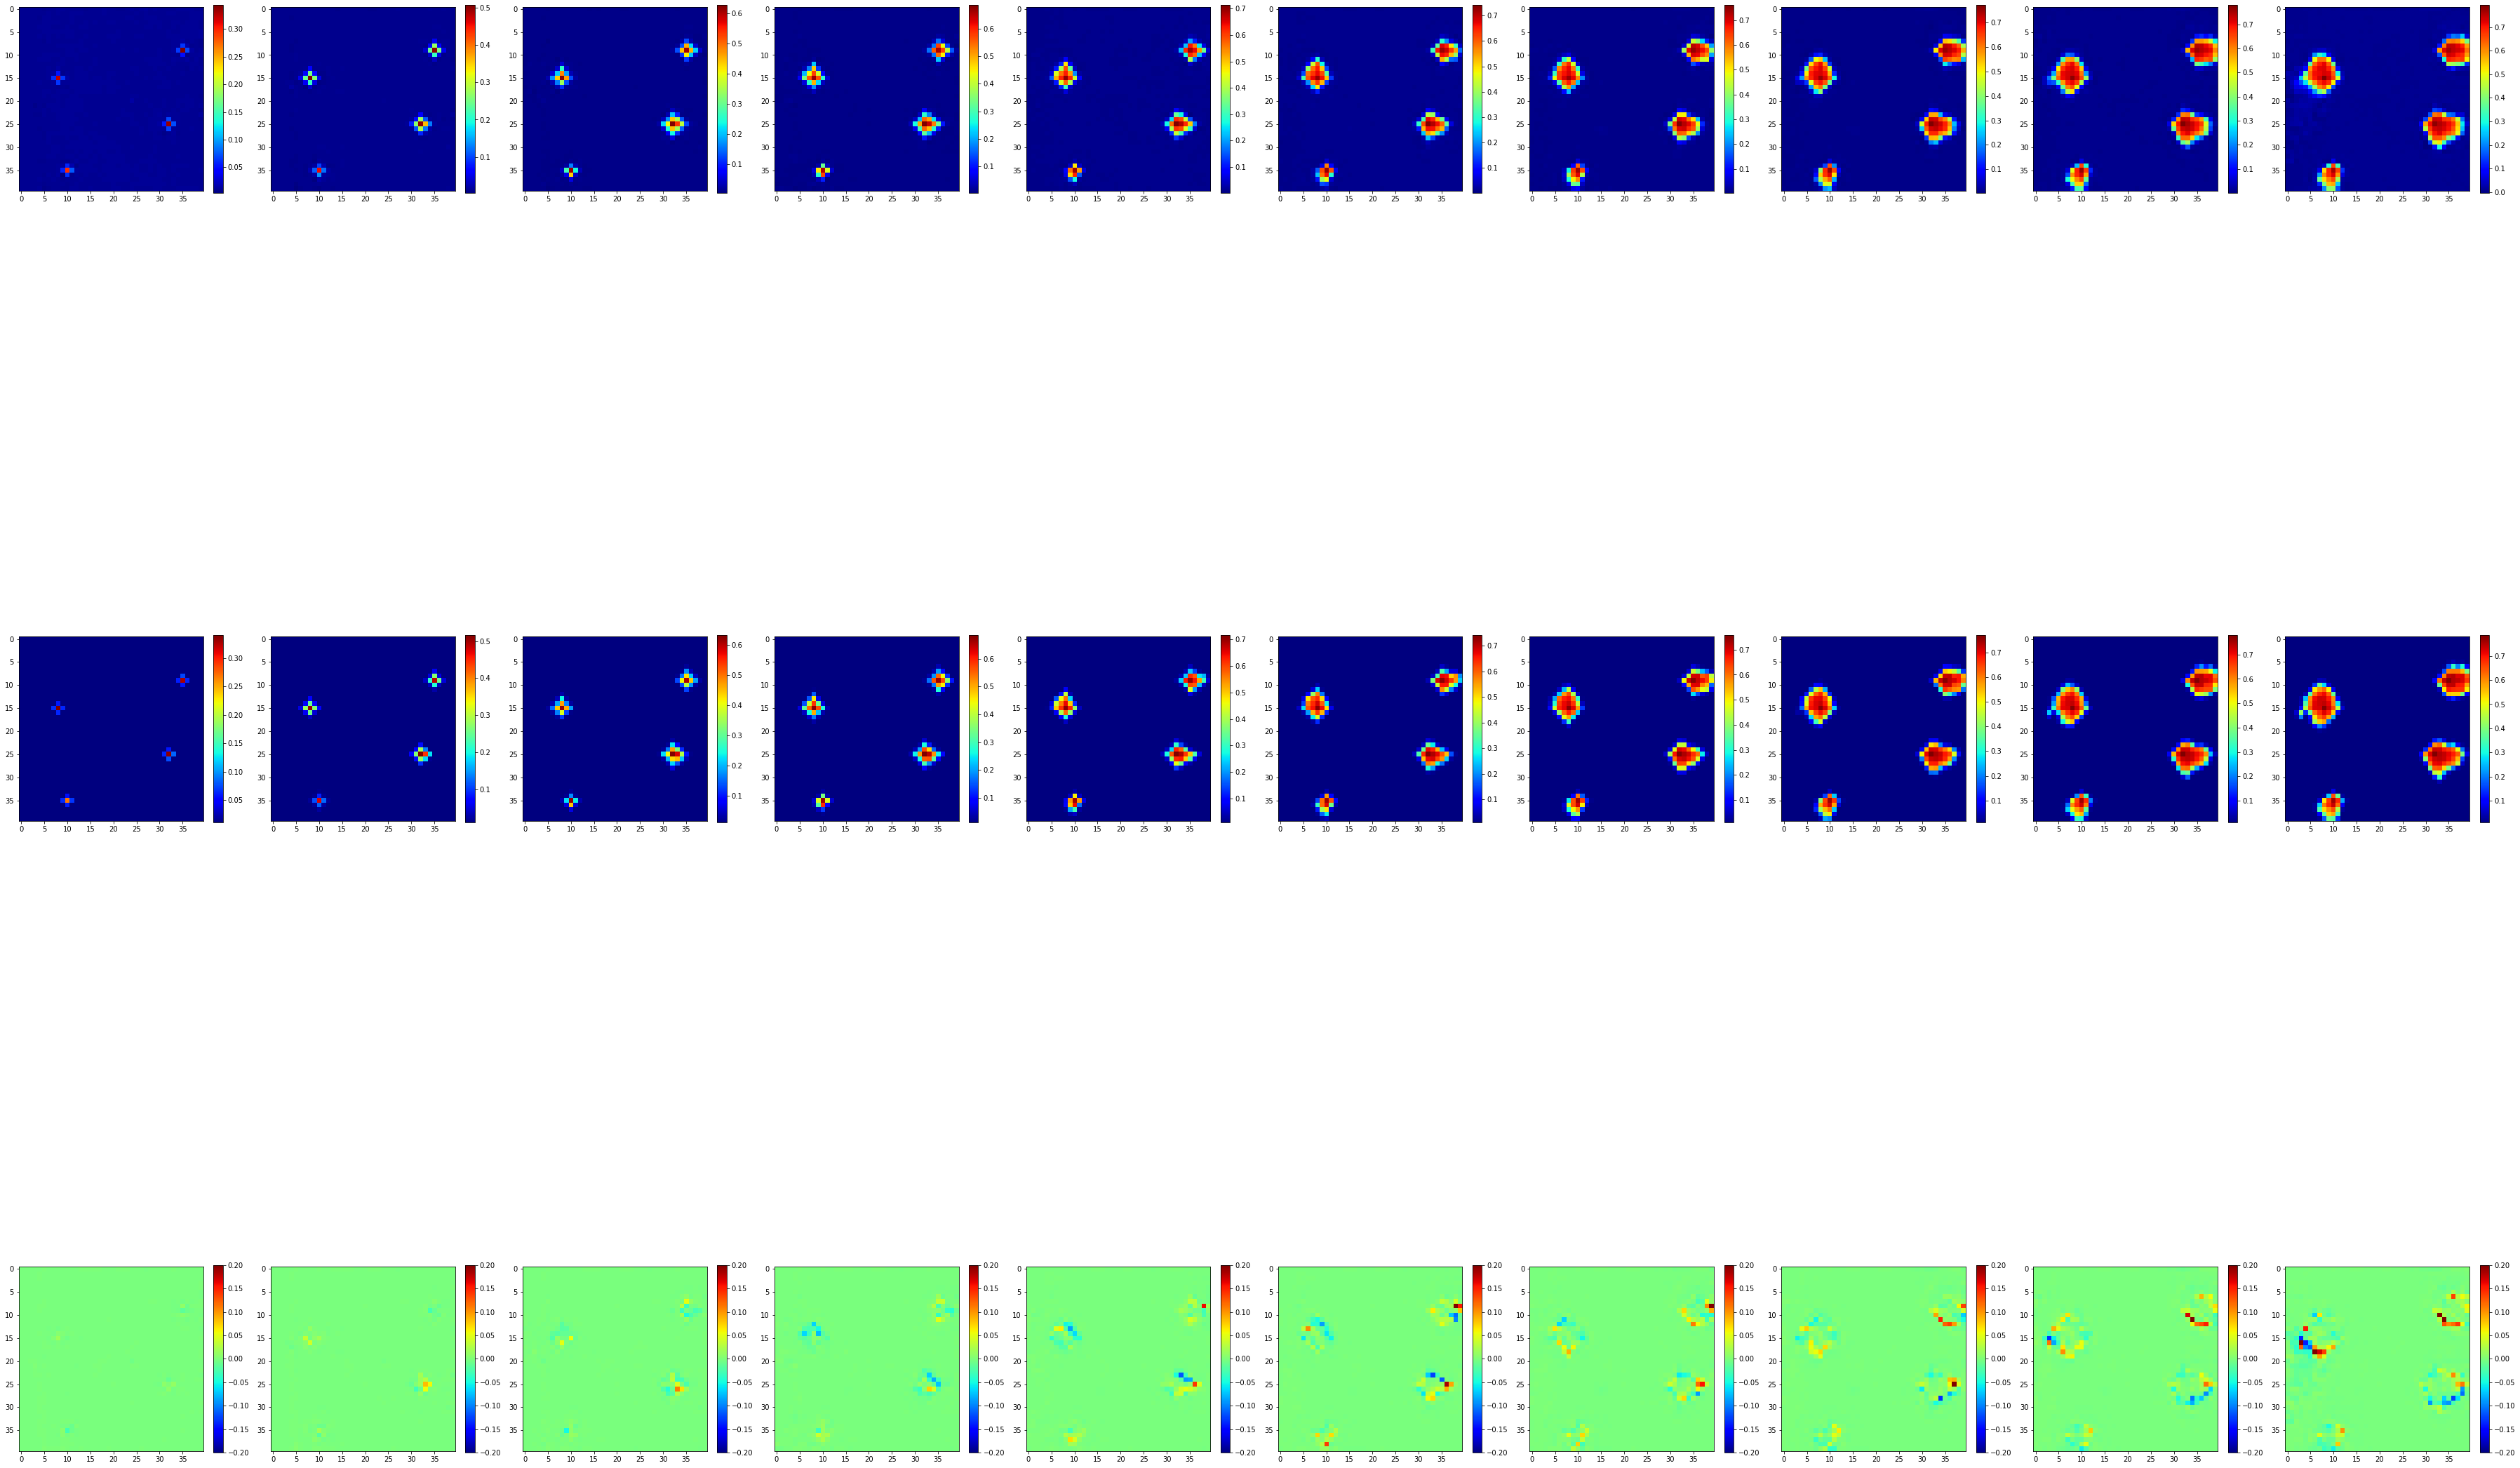

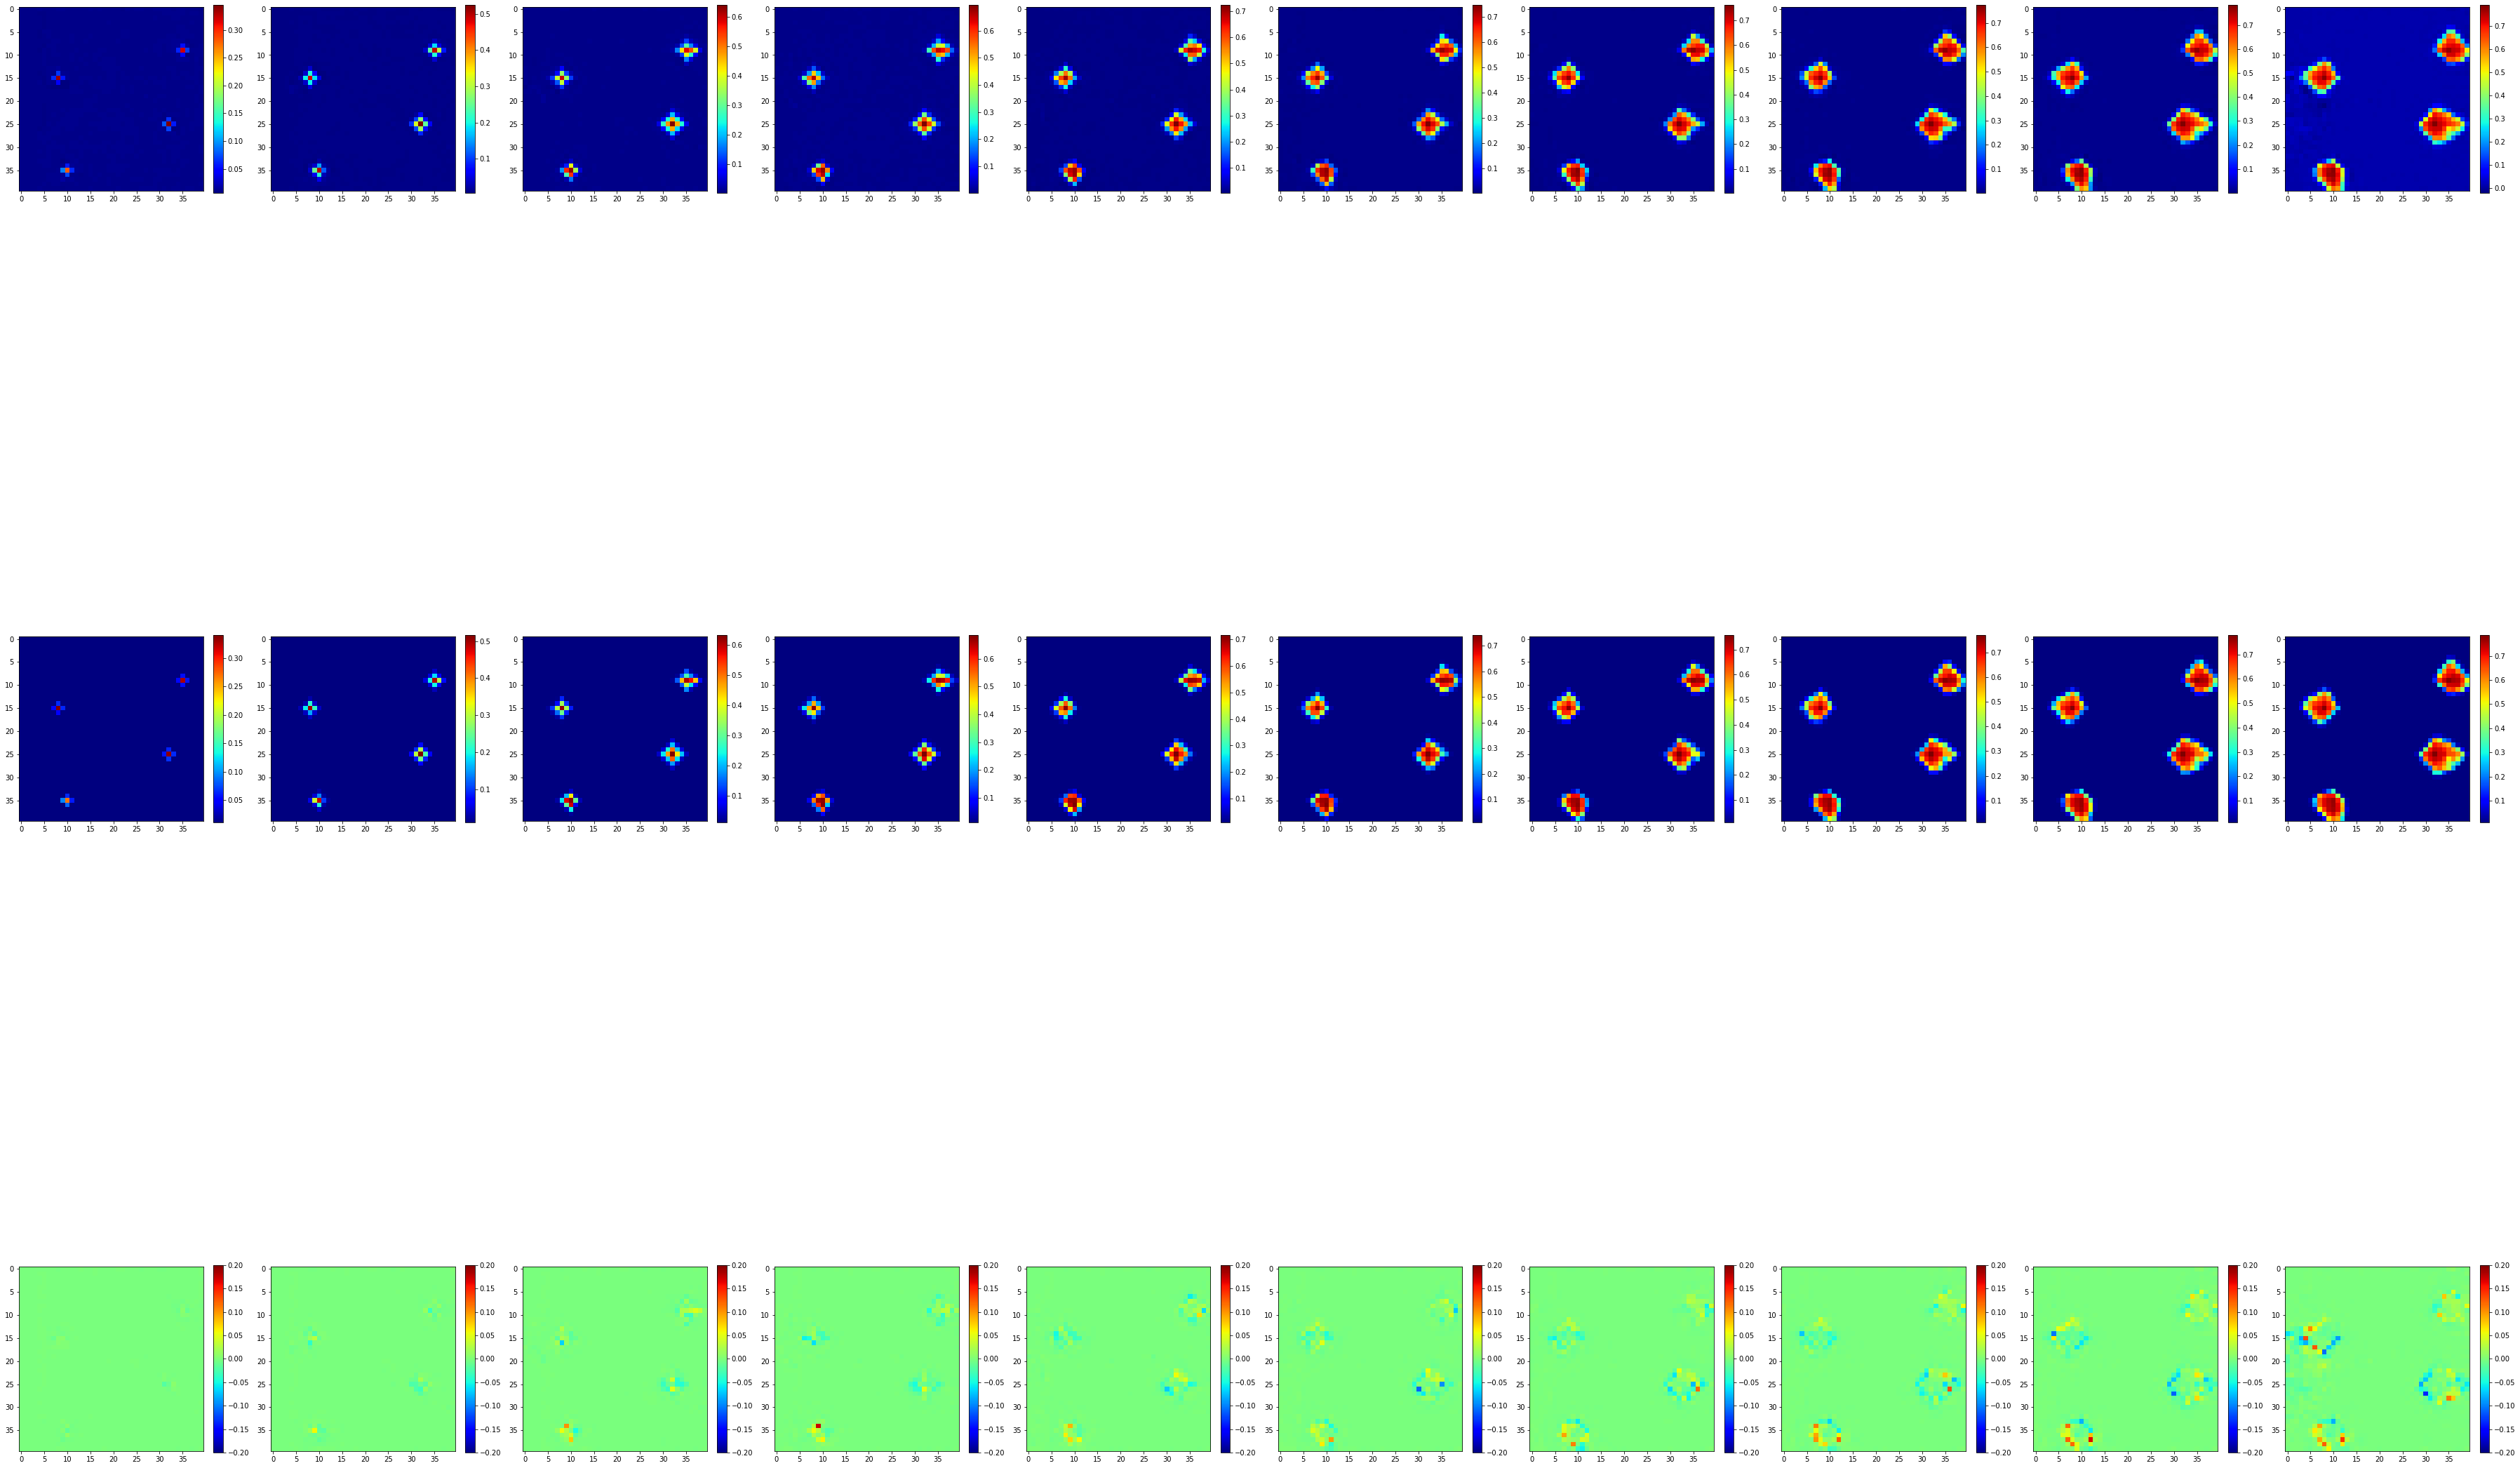

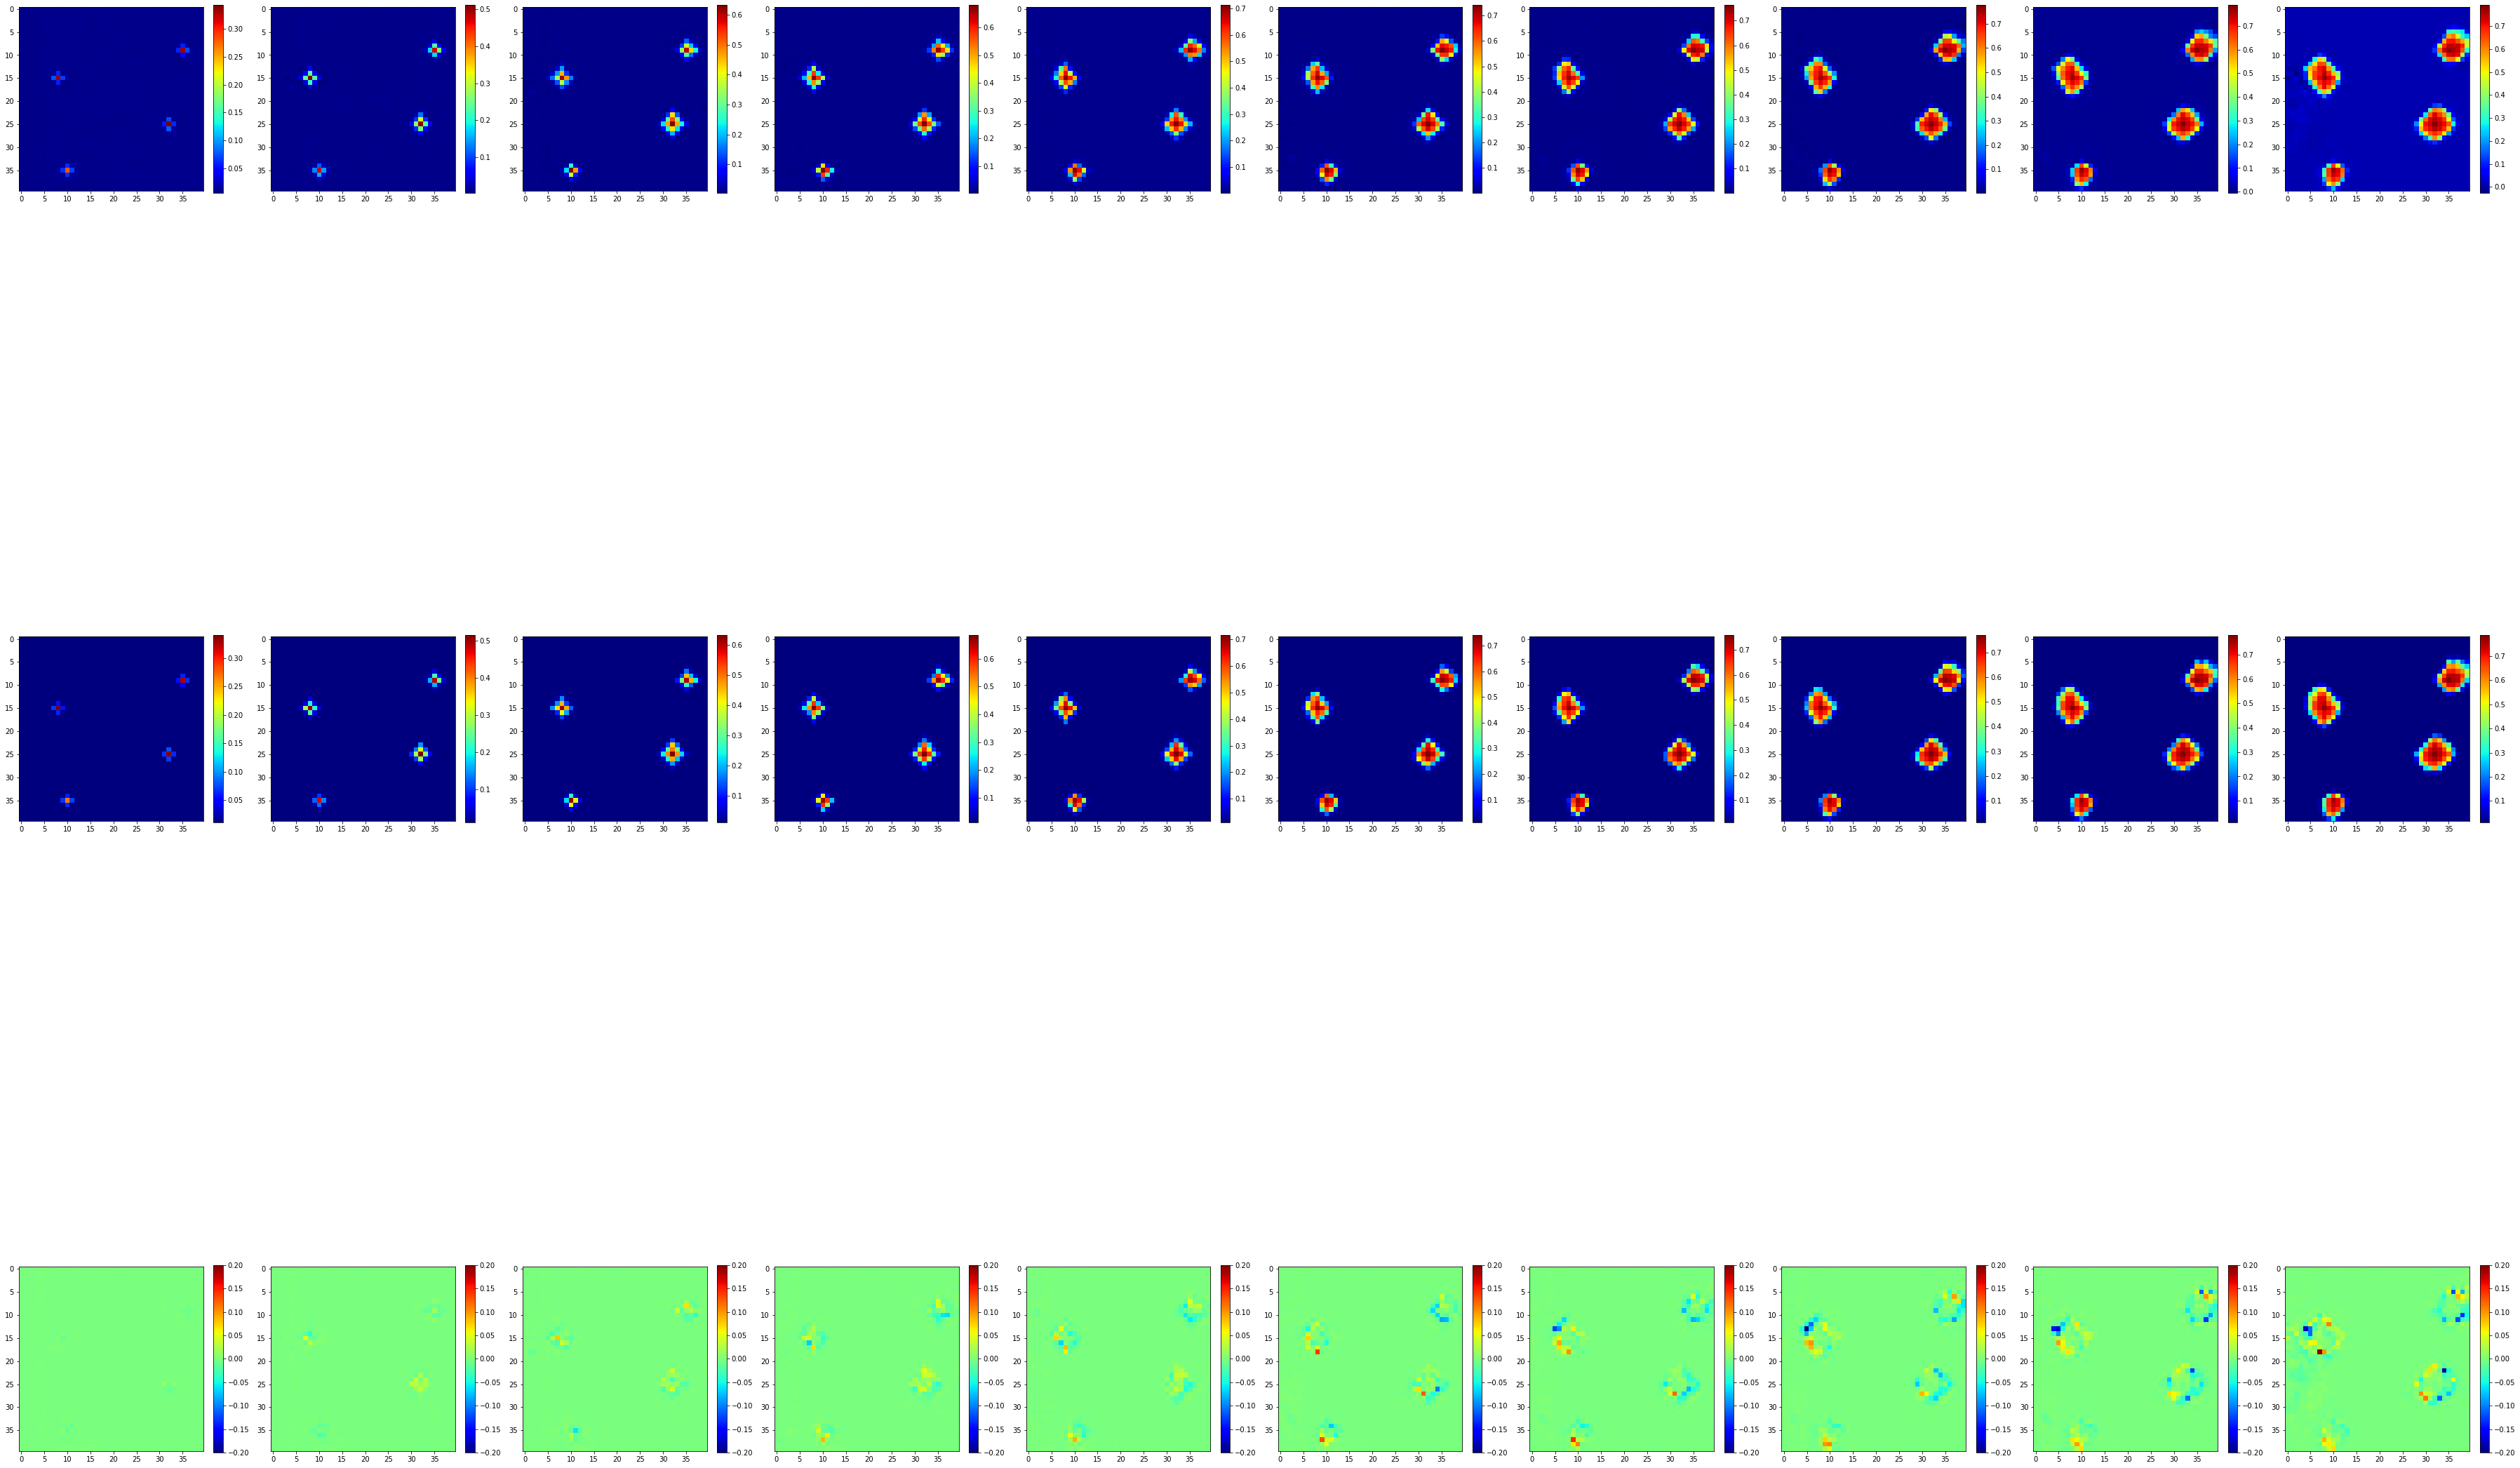

In [16]:
ind_case = [0, 10, 20]
ind_z = 0
layer = 7
for k in ind_case:
    plt.figure(figsize=(50,50))
    for i_tstep in range(depth):
        plt.subplot(3, depth, i_tstep+1)
       
        plt.imshow(sat_pred[k, i_tstep, layer, :, :])
        plt.colorbar(fraction=0.046)
        plt.subplot(3, depth, i_tstep+1+depth)
        plt.imshow(sat_true[k, i_tstep, layer, :, :])
        plt.colorbar(fraction=0.046)
        
        plt.subplot(3, depth, i_tstep+1+2*depth)
        plt.imshow(sat_true[k, i_tstep, layer, :, :] - sat_pred[k, i_tstep, layer, :, :])

        plt.colorbar(fraction=0.046)
        plt.clim([-0.2, 0.2])
        plt.tight_layout()
plt.show()

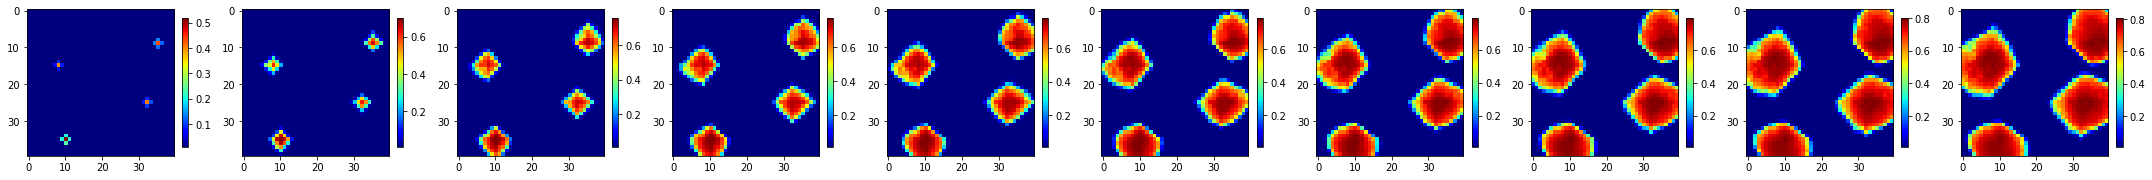

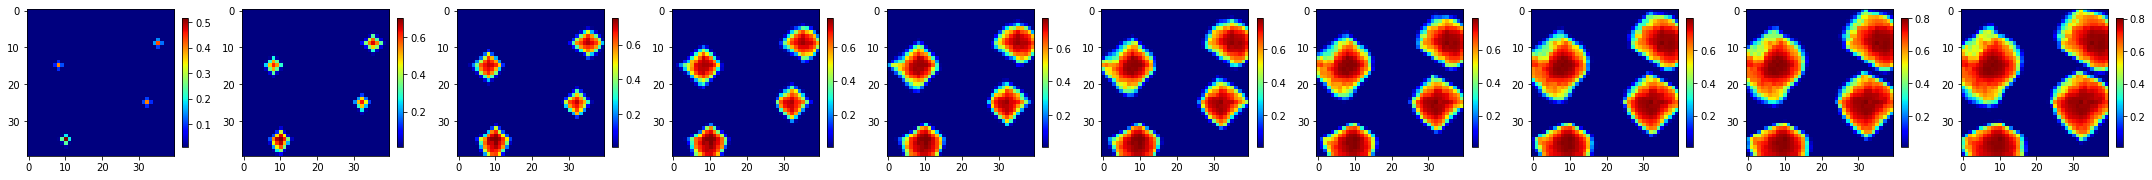

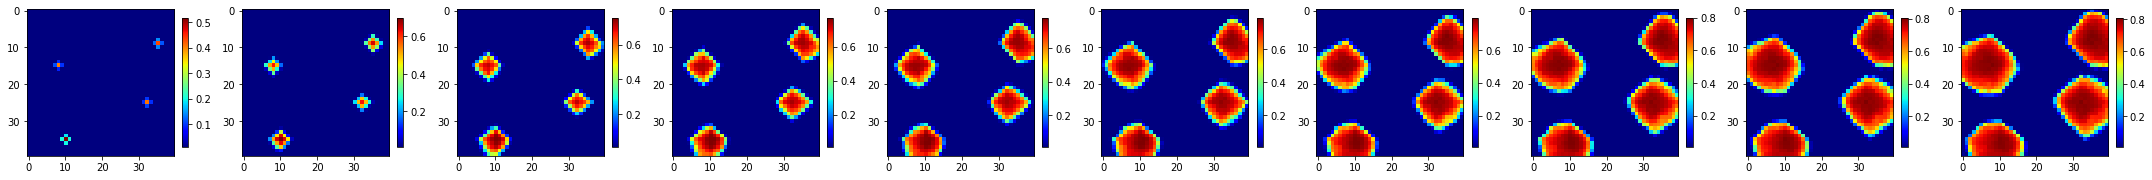

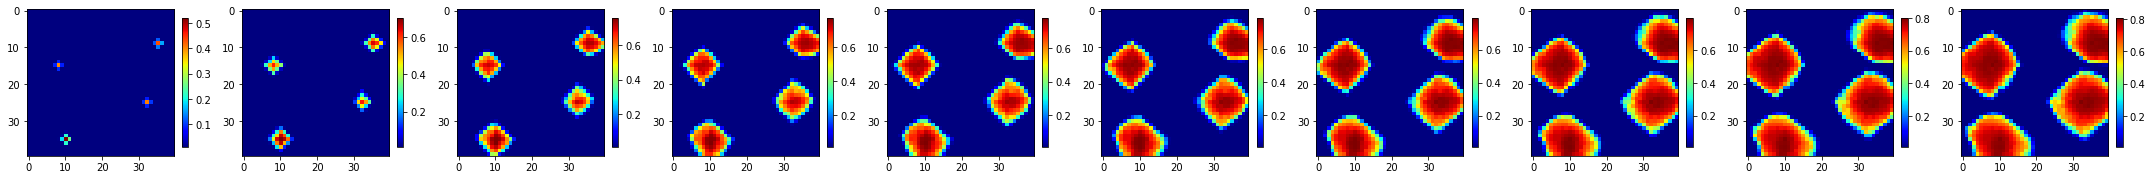

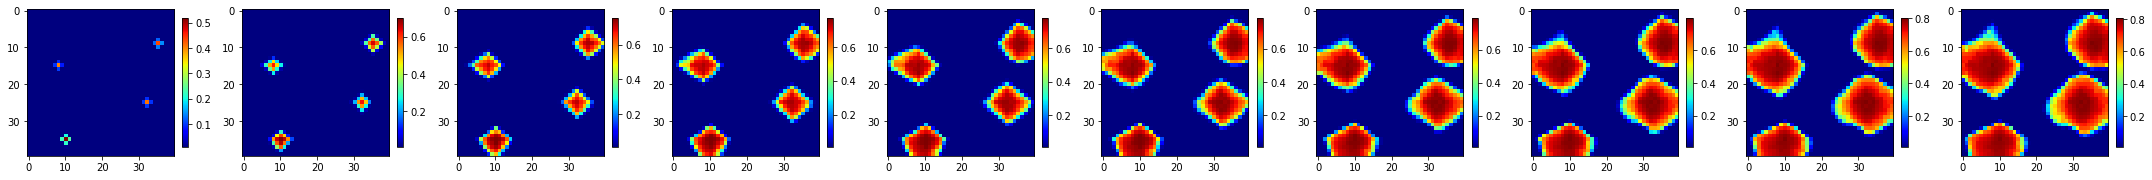

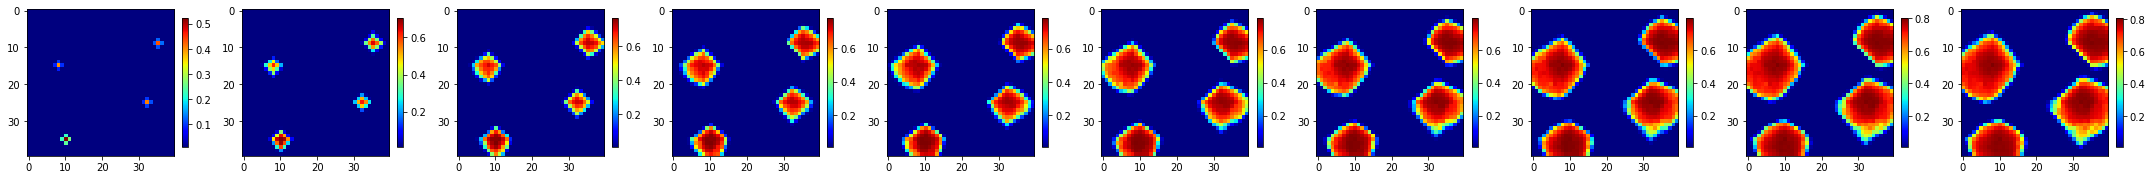

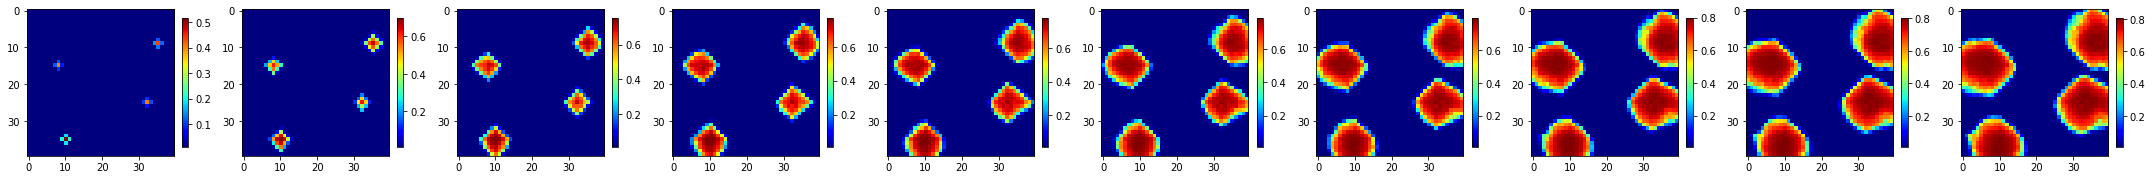

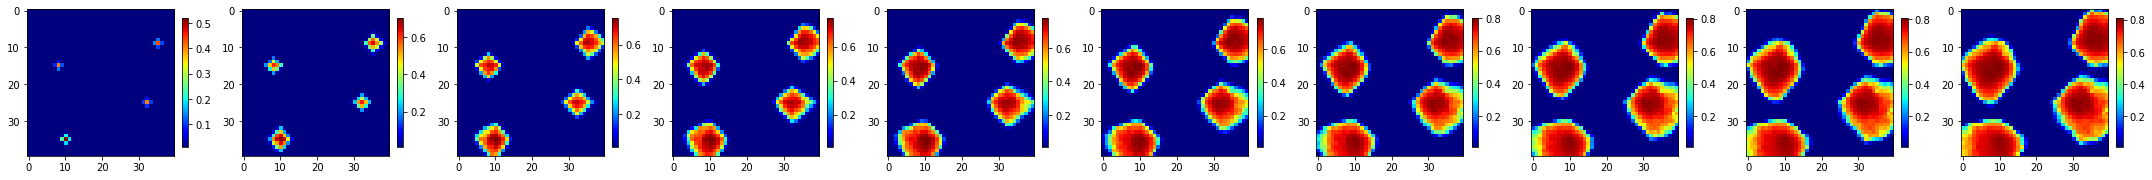

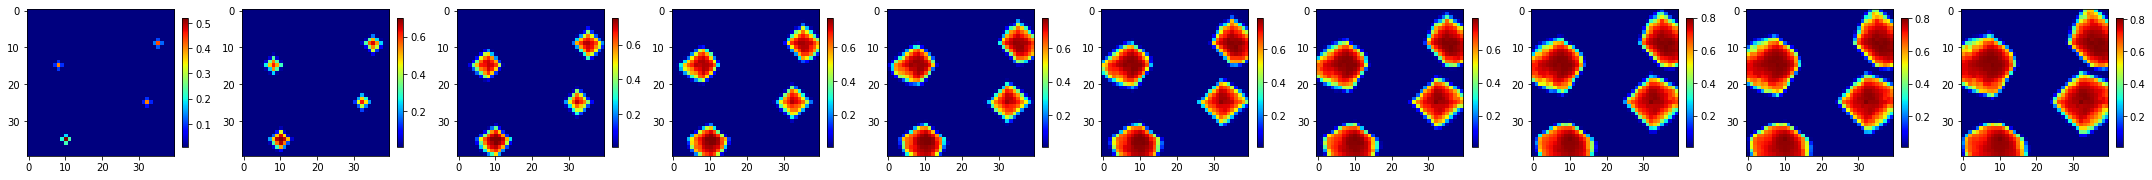

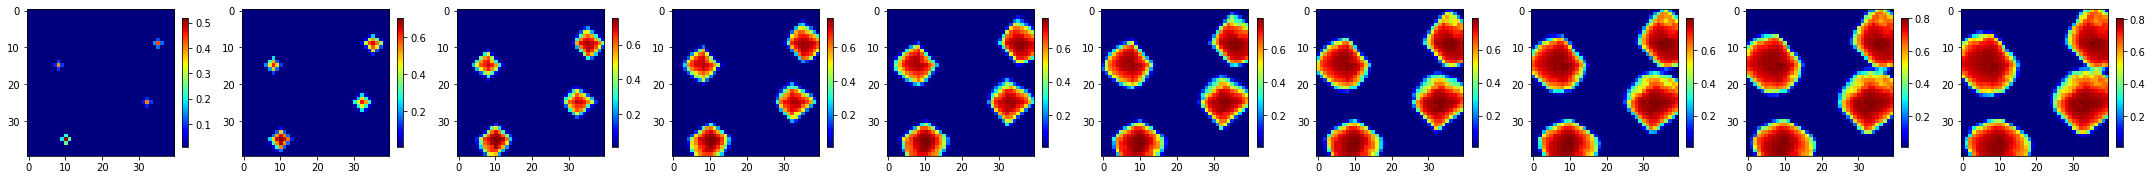

In [17]:
for k in range(10):
    plt.figure(figsize=(30, 5))
    for t in range(10):
        plt.subplot(1, 10, t + 1)
        plt.imshow(sat_true[k, t, -1, :, :])
        plt.colorbar(fraction = 0.04)
        plt.tight_layout()

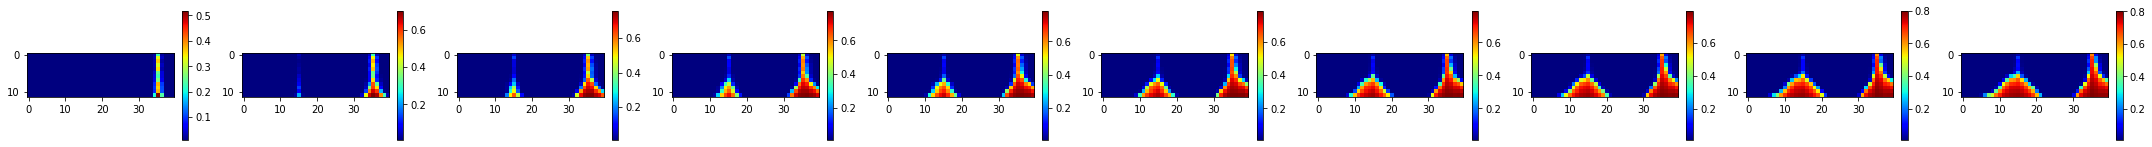

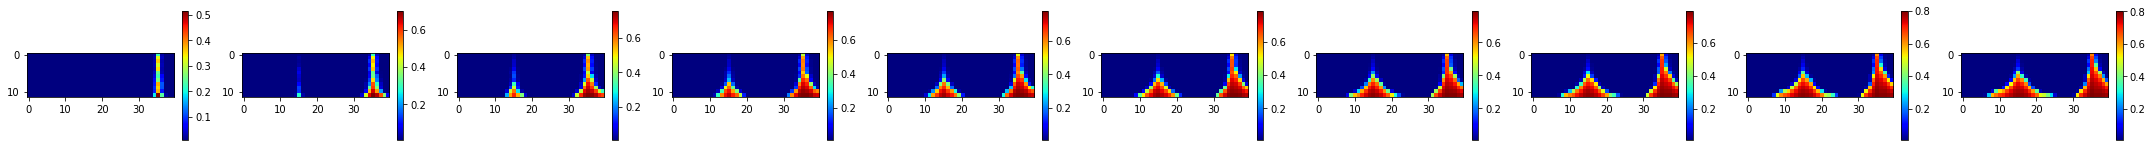

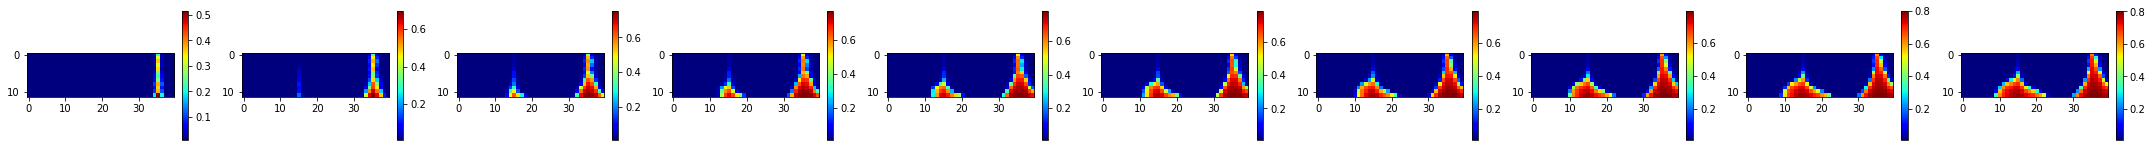

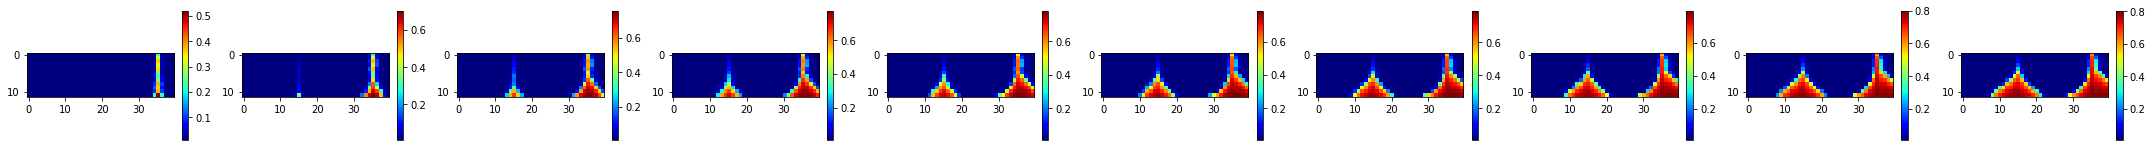

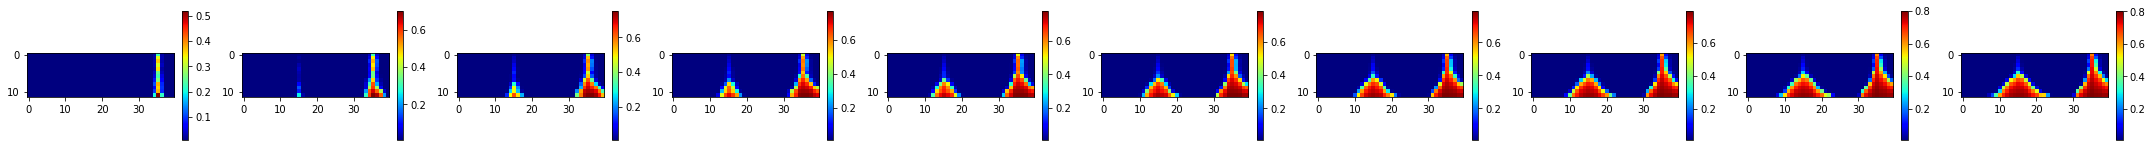

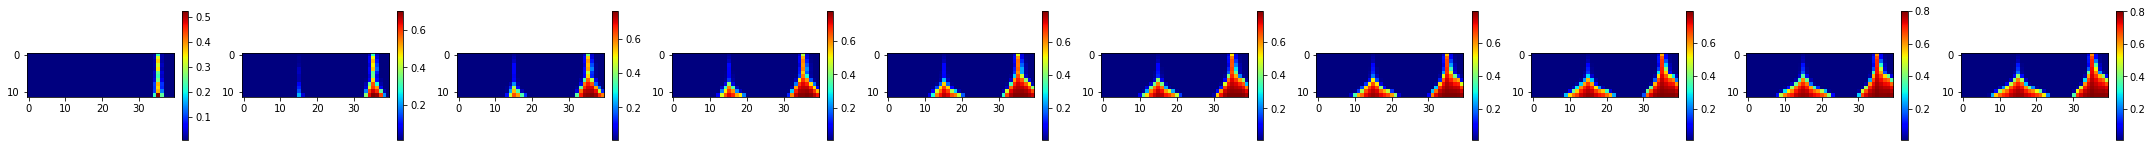

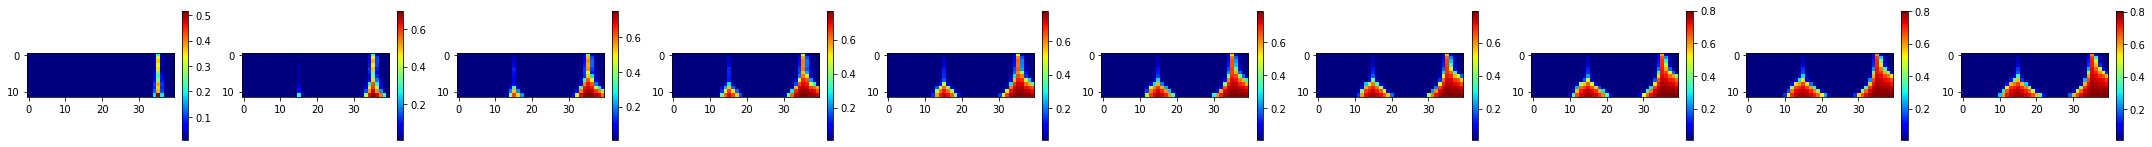

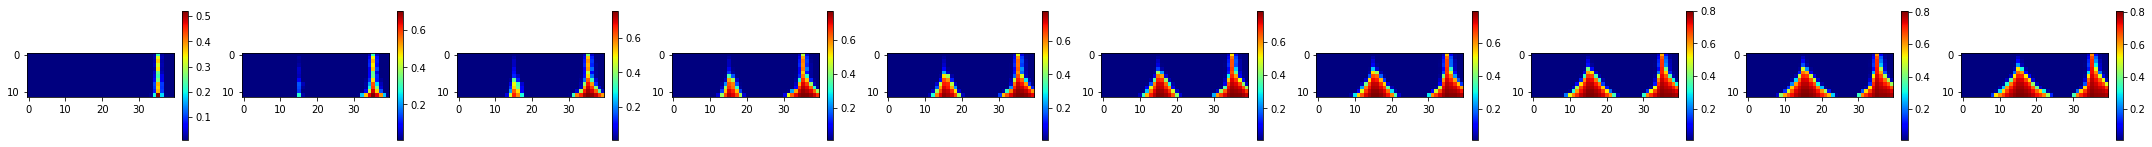

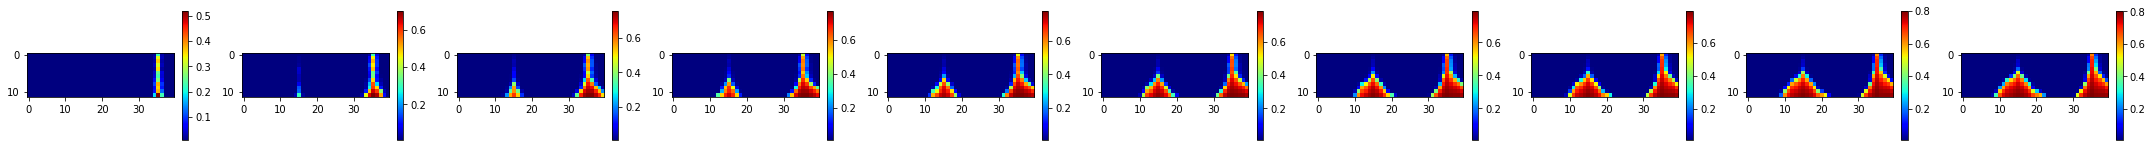

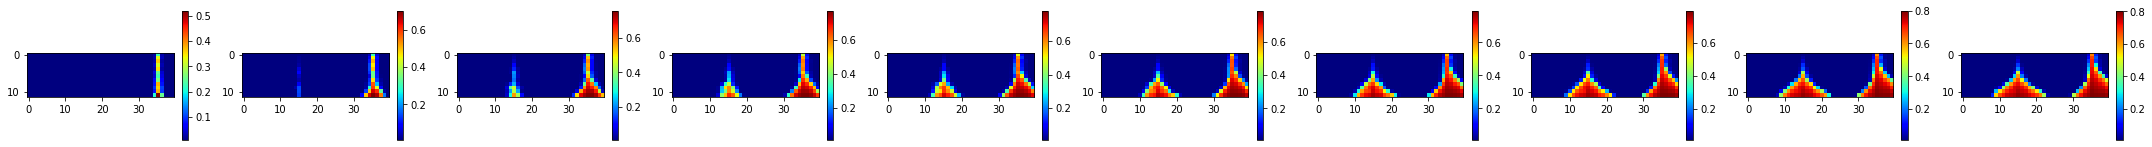

In [18]:
for k in range(10):
    plt.figure(figsize=(30, 5))
    for t in range(10):
        plt.subplot(1, 10, t + 1)
        plt.imshow(sat_true[k, t, :, :, 10])
        plt.colorbar(fraction = 0.04)
        plt.tight_layout()

In [19]:
well_loc_x = [8, 10, 35, 32]
well_loc_y = [15, 35, 9, 25]

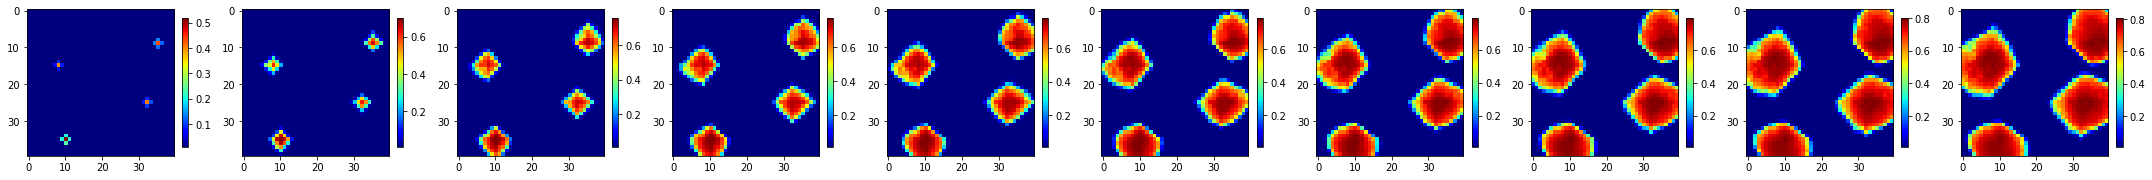

In [20]:
for k in range(1):
    plt.figure(figsize=(30, 5))
    for t in range(10):
        plt.subplot(1, 10, t + 1)
        plt.imshow(sat_true[k, t, -1, :, :])
        plt.colorbar(fraction = 0.04)
        plt.tight_layout()

# Compute relative error

In [21]:
sat_true.shape

(500, 10, 12, 40, 40)

In [22]:
relative_error = np.mean(np.abs(sat_pred - sat_true) / (sat_true + 0.01), axis = (1,2,3,4))

In [23]:
relative_error.shape

(500,)

In [24]:
ranks = np.argsort(relative_error)

In [25]:
relative_error[ranks[250]]

0.053374813196224426

In [26]:
relative_error[2]

0.0533071262407886

In [27]:
relative_error[57]

0.0530948926993929

In [28]:
relative_error[11]

0.05328757495533773

In [29]:
np.where(ranks == 2)

(array([241]),)

In [30]:
relative_error[241]

0.05304038409730918

In [31]:
np.where(ranks == 57)

(array([216]),)

In [32]:
np.where(ranks == 11)

(array([240]),)

In [33]:
np.where(ranks == 147)

(array([339]),)

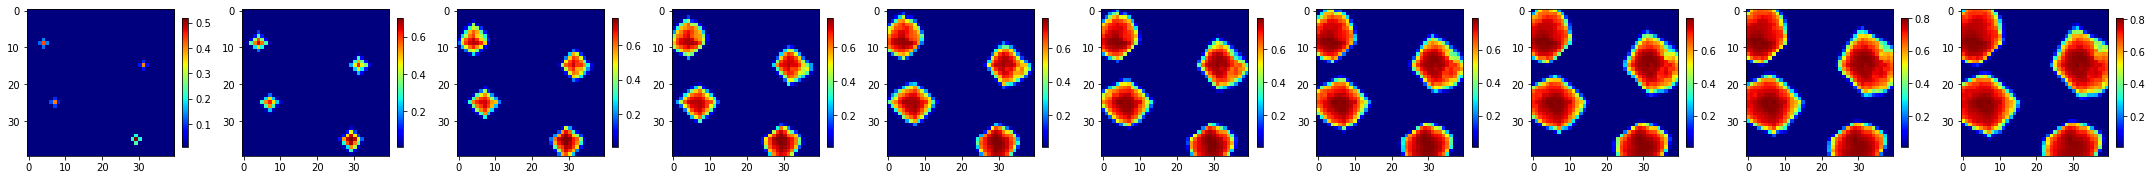

In [34]:
for k in range(1):
    plt.figure(figsize=(30, 5))
    for t in range(10):
        plt.subplot(1, 10, t + 1)
        plt.imshow(sat_true[k, t, -1, :, ::-1])
        plt.colorbar(fraction = 0.04)
        plt.tight_layout()

In [35]:

area_pred = sat_pred[:, :, -1, 7, 9]
area_true = sat_true[:, :, -1, 7, 9]

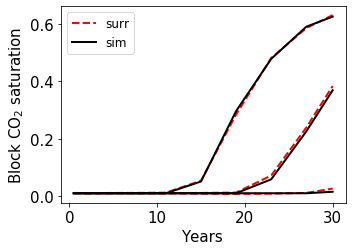

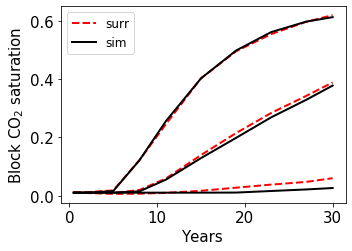

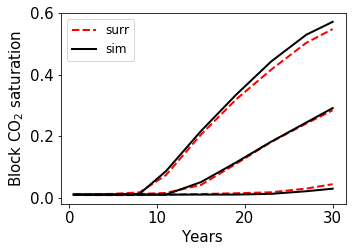

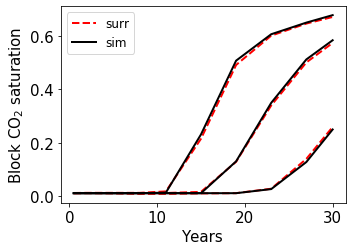

In [37]:

tsteps = [0.5, 2.0 , 5.0, 8.0, 11., 15., 19., 23., 27., 30.]


obs_loc_x = [9, 10, 35, 31]
obs_loc_y = [7, 30, 15, 32]


for i in range(4):
    y, x = obs_loc_y[i], obs_loc_x[i]
    area_pred = sat_pred[:, :, -1, y, x]
    area_true = sat_true[:, :, -1, y, x]
    
    plt.figure(figsize = (5, 3.6))

    plt.plot(tsteps, np.percentile(area_pred, q = 10, axis = 0), 'r--', label = 'surr', linewidth = 2)
    plt.plot(tsteps, np.percentile(area_pred, q = 50, axis = 0), 'r--', linewidth = 2)
    plt.plot(tsteps, np.percentile(area_pred, q = 90, axis = 0), 'r--', linewidth = 2)

    plt.plot(tsteps, np.percentile(area_true, q = 10, axis = 0), color = 'k', label = 'sim', linewidth = 2)
    plt.plot(tsteps, np.percentile(area_true, q = 50, axis = 0), color = 'k', linewidth = 2)
    plt.plot(tsteps, np.percentile(area_true, q = 90, axis = 0), color = 'k', linewidth = 2)

    plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=15)
    plt.xlabel('Years', fontsize=15)
    plt.ylabel('Block CO$_2$ saturation', fontsize = 15)
    plt.legend( prop={'size': 12})
    plt.tight_layout()
    
    plt.savefig('./saved_plots/test_saturation_well%d.pdf'%(i + 1))
    plt.savefig('./saved_plots/test_saturation_well%d.png'%(i + 1))

In [23]:
hr = h5py.File('./RS/rs_logk_601_posterior.h5', 'r')
PCA_logk = np.array(hr.get('logk'))
hr.close()

hw = h5py.File('PCA_model_vs_SGeMS_model.h5', 'w')
hw.create_dataset('PCA_model', data = PCA_logk[:3, ...])
hw.create_dataset('SGeMS_model', data = logk[[0, 80, 100], ...])
hw.close()

In [24]:
train_x.max()

5.6104

In [25]:
for i in range(4):
    y, x = obs_loc_y[i], obs_loc_x[i]
    area_pred = sat_pred[:, :, -1, y, x]
    area_true = sat_true[:, :, -1, y, x]
    
    plt.figure(figsize = (5, 3.6))

    p5 = np.percentile(area_true[:, -1], q = 5, axis = 0)
    p5_ind = np.abs(p5 - area_true[:, -1]).argmin()
    p95 = np.percentile(area_true[:, -1], q = 95, axis = 0) 
    p95_ind = np.abs(p95 - area_true[:, -1]).argmin()
    
    print('Near well {}, p5 index is {}, p95 index is {}'.format(i + 1, p5_ind, p95_ind))
    

Near well 1, p5 index is 2, p95 index is 57
Near well 2, p5 index is 11, p95 index is 147
Near well 3, p5 index is 15, p95 index is 145
Near well 4, p5 index is 60, p95 index is 87


<Figure size 360x259.2 with 0 Axes>

<Figure size 360x259.2 with 0 Axes>

<Figure size 360x259.2 with 0 Axes>

<Figure size 360x259.2 with 0 Axes>

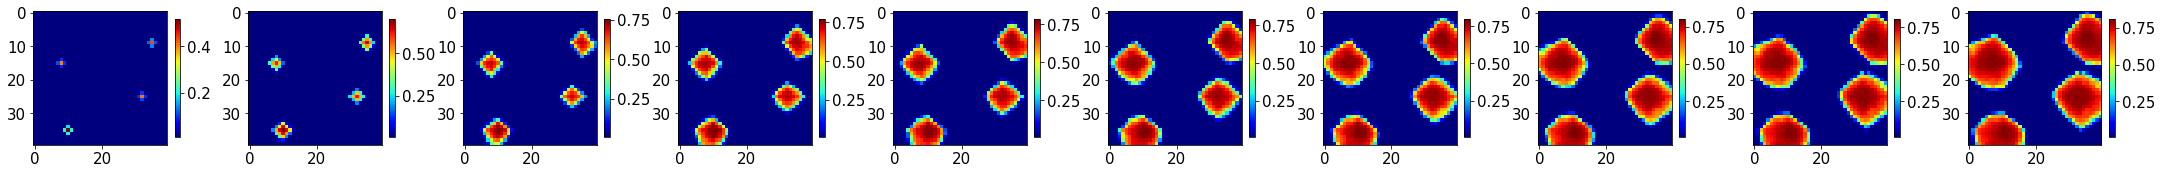

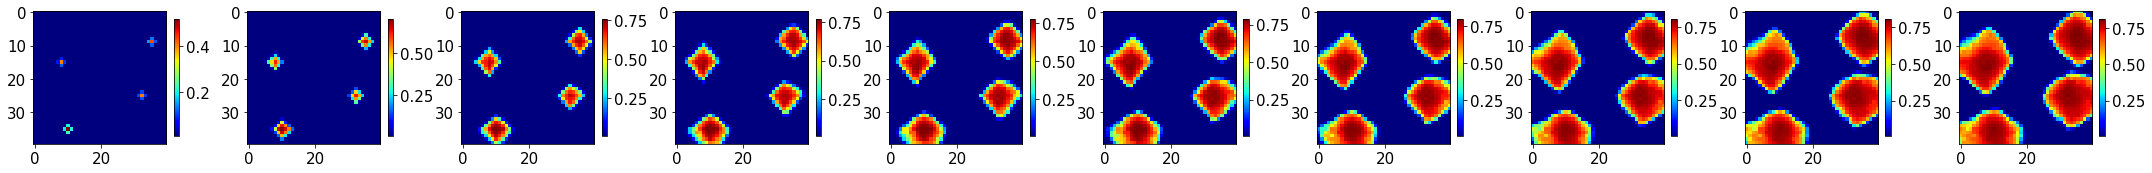

In [26]:
for k in [2, 57]:
    plt.figure(figsize=(30, 5))
    for t in range(10):
        plt.subplot(1, 10, t + 1)
        plt.imshow(sat_true[k, t, -1, :, :])
        plt.colorbar(fraction = 0.04)
        plt.tight_layout()

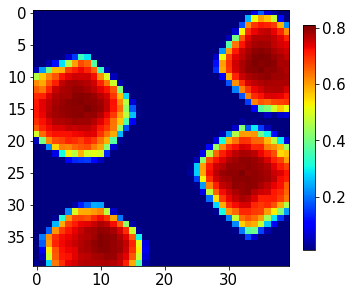

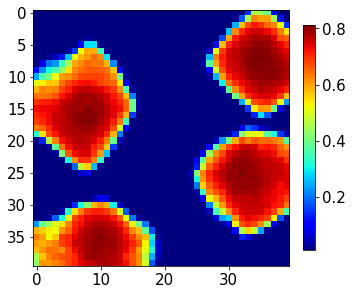

In [27]:
for k in [2, 57]:
    plt.figure(figsize=(5, 5))
 
    plt.imshow(sat_true[k, -1, -1, :, :])
    plt.colorbar(fraction = 0.04)
    plt.tight_layout()

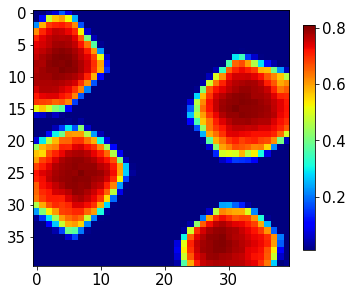

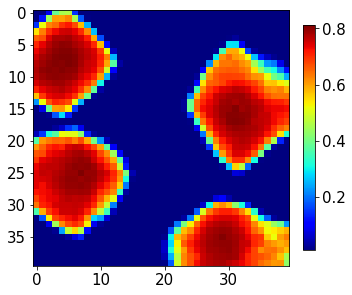

In [29]:
for k in [2, 57]:
    plt.figure(figsize=(5, 5))
 
    plt.imshow(sat_true[k, -1, -1, ::, ::-1])
    plt.colorbar(fraction = 0.04)
    plt.tight_layout()

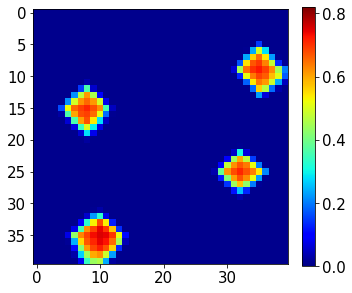

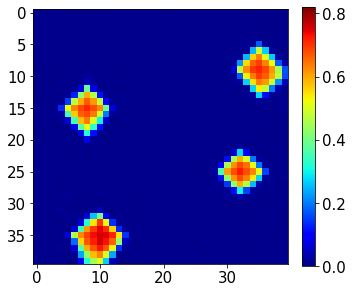

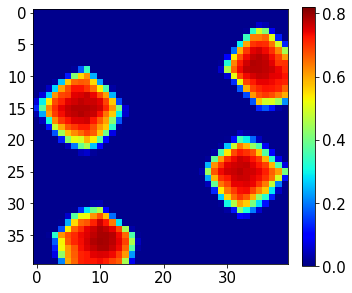

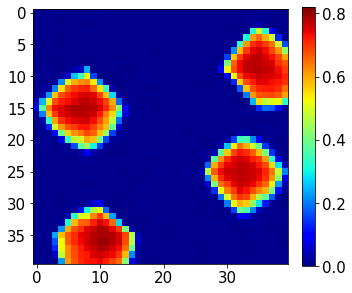

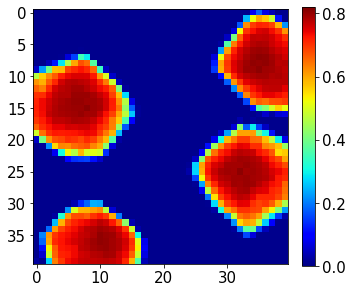

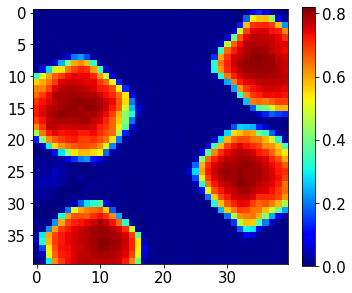

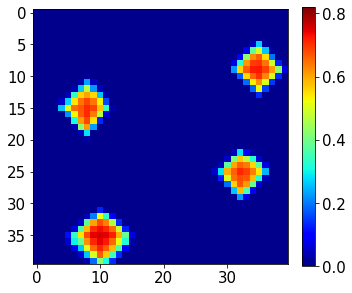

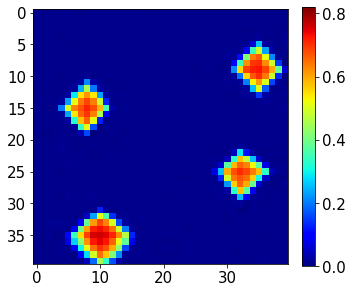

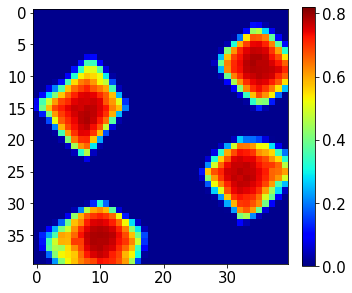

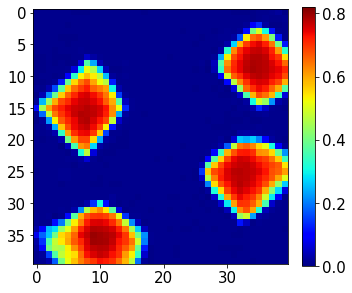

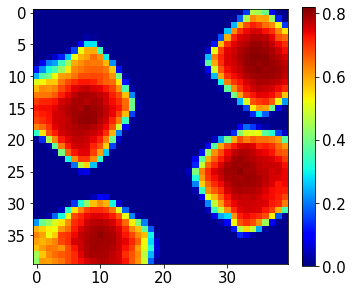

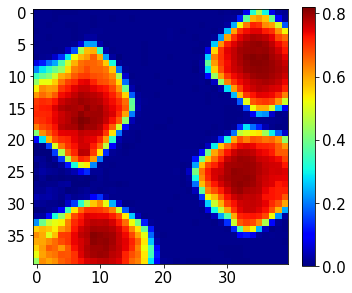

In [33]:
picked_case = [2, 57]
picked_tstep = [2, 5, -1]

for k in picked_case:
    for t in picked_tstep:
        
        plt.figure(figsize=(5, 5))
        plt.imshow(sat_true[k, t, -1, :, :], vmin = 0.0, vmax = 0.82)
        clb = plt.colorbar(fraction = 0.046)
        #clb.ax.set_title('MPa', size=15)
        plt.tight_layout()
        
        plt.savefig('./saved_field_plots/sat_true_tstep{}_well1_case{}.png'.format(t, k))
        
        
        plt.figure(figsize=(5, 5))
        plt.imshow(sat_pred[k, t, -1, :, :] , vmin = 0.0, vmax = 0.82)
        clb = plt.colorbar(fraction = 0.046)
        #clb.ax.set_title('MPa', size=15)
        plt.tight_layout()
        plt.savefig('./saved_field_plots/sat_pred_tstep{}_well1_case{}.png'.format(t, k))

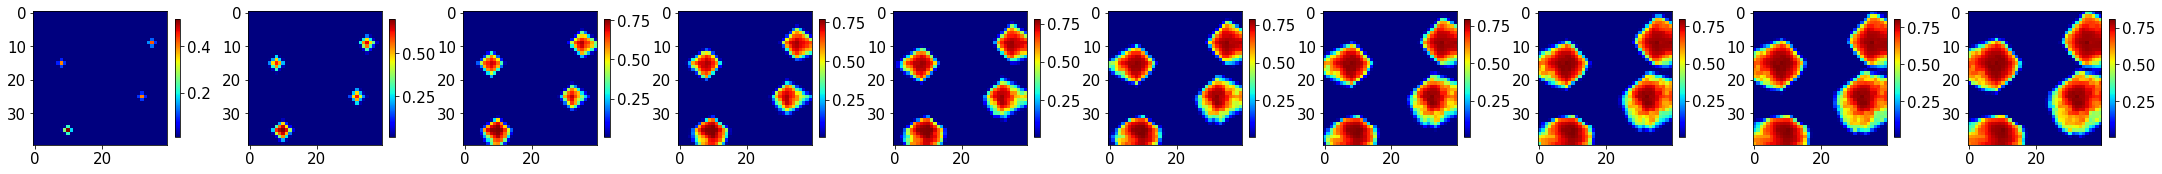

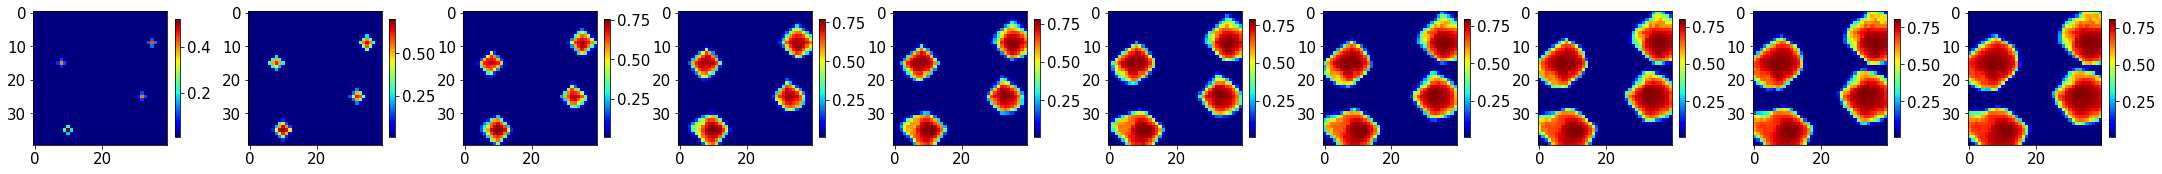

In [27]:
for k in [11, 147]:
    plt.figure(figsize=(30, 5))
    for t in range(10):
        plt.subplot(1, 10, t + 1)
        plt.imshow(sat_true[k, t, -1, :, :])
        plt.colorbar(fraction = 0.04)
        plt.tight_layout()

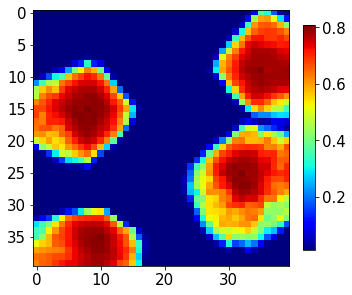

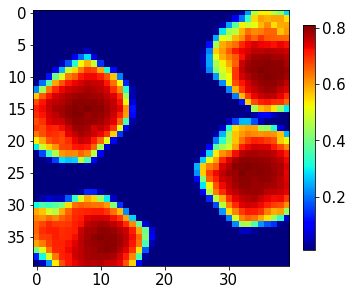

In [28]:
for k in [11, 147]:
    plt.figure(figsize=(5, 5))
 
    plt.imshow(sat_true[k, -1, -1, :, :])
    plt.colorbar(fraction = 0.04)
    plt.tight_layout()

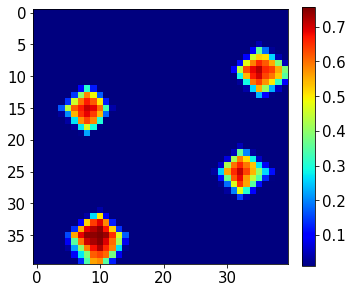

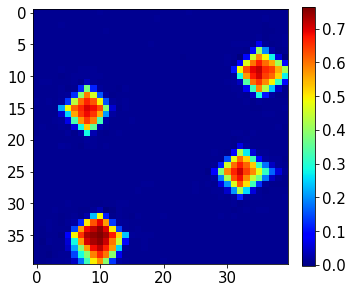

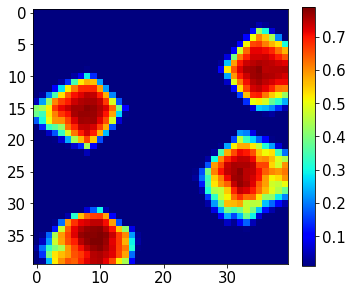

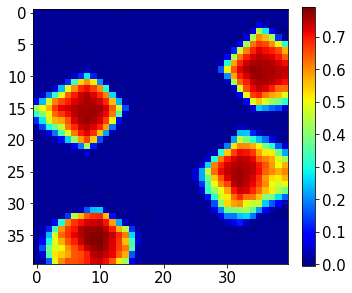

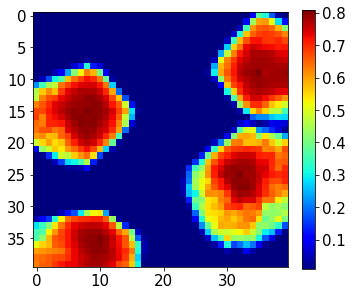

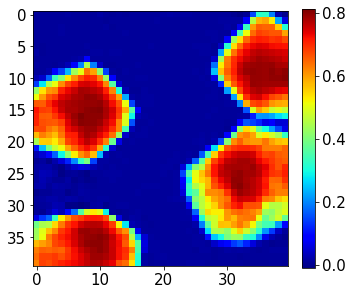

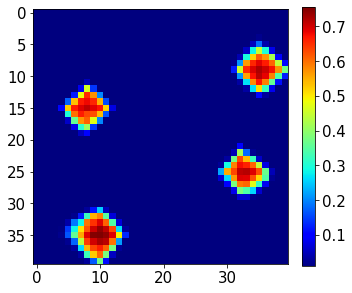

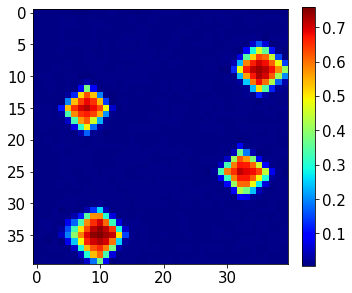

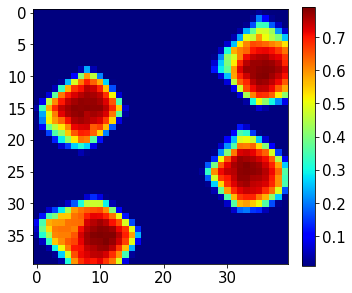

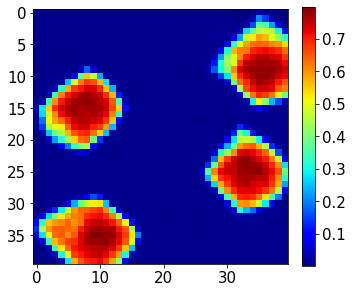

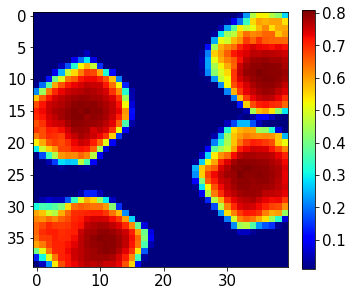

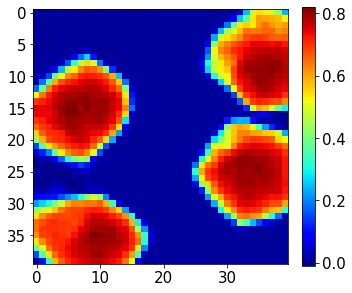

In [29]:
picked_case = [11, 147]
picked_tstep = [2, 5, 9]

for k in picked_case:
    for t in picked_tstep:
        
        plt.figure(figsize=(5, 5))
        plt.imshow(sat_true[k, t, -1, :, :] )
        clb = plt.colorbar(fraction = 0.046)
        #clb.ax.set_title('MPa', size=15)
        plt.tight_layout()
        
        plt.savefig('./saved_field_plots/sat_true_tstep{}_well2_case{}.png'.format(t, k))
        
        
        plt.figure(figsize=(5, 5))
        plt.imshow(sat_pred[k, t, -1, :, :] )
        clb = plt.colorbar(fraction = 0.046)
        #clb.ax.set_title('MPa', size=15)
        plt.tight_layout()
        plt.savefig('./saved_field_plots/sat_pred_tstep{}_well2_case{}.png'.format(t, k))

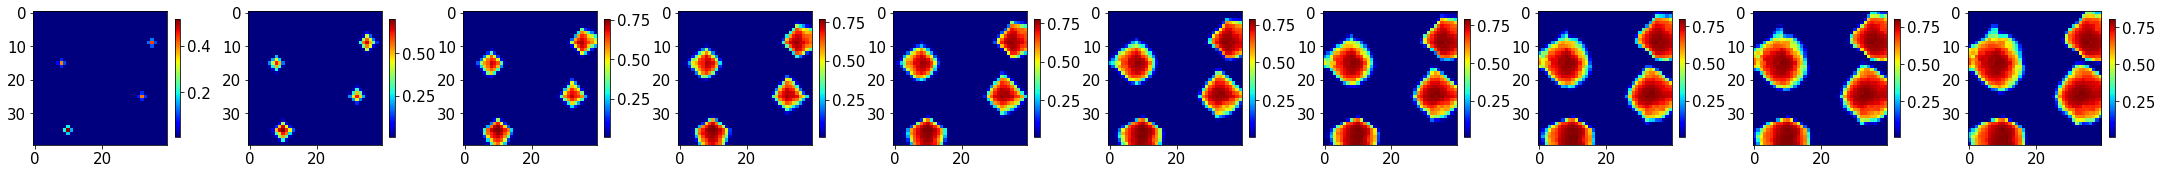

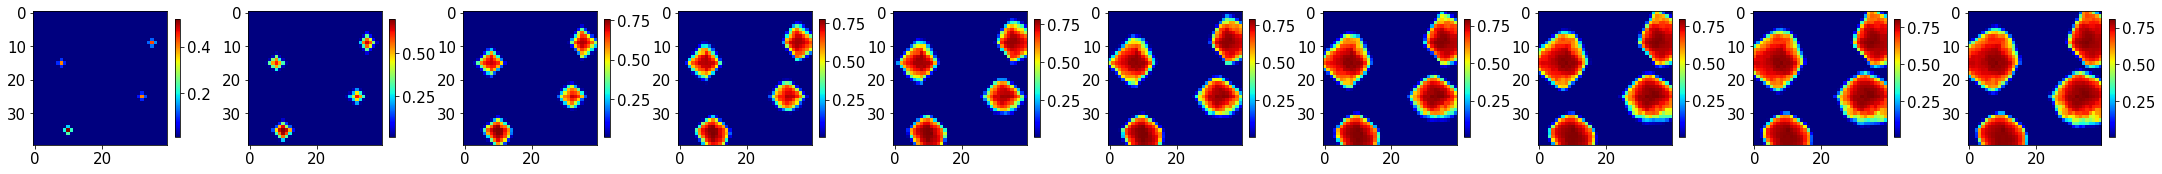

In [29]:
for k in [15, 145]:
    plt.figure(figsize=(30, 5))
    for t in range(10):
        plt.subplot(1, 10, t + 1)
        plt.imshow(sat_true[k, t, -1, :, :])
        plt.colorbar(fraction = 0.04)
        plt.tight_layout()

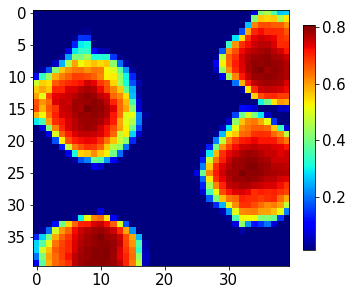

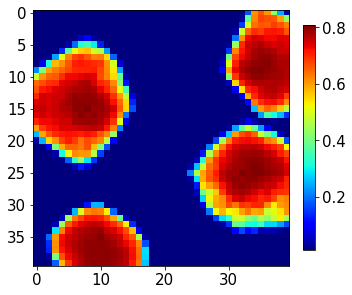

In [30]:
for k in [15, 145]:
    plt.figure(figsize=(5, 5))
 
    plt.imshow(sat_true[k, -1, -1, :, :])
    plt.colorbar(fraction = 0.04)
    plt.tight_layout()

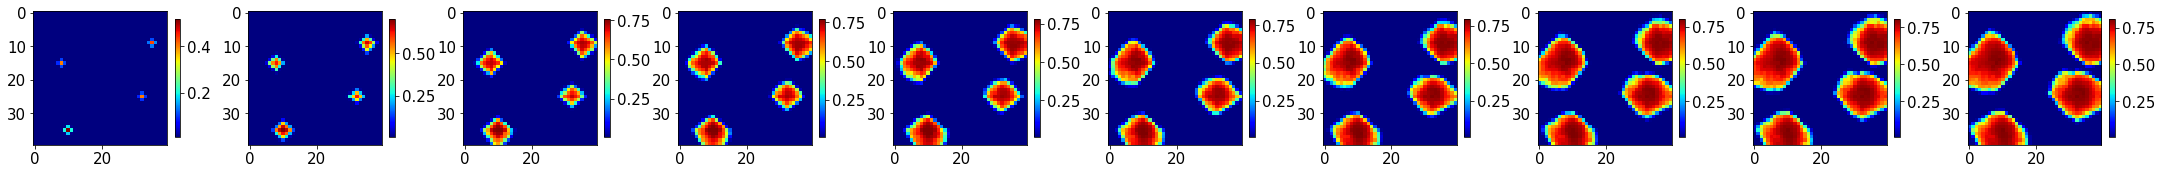

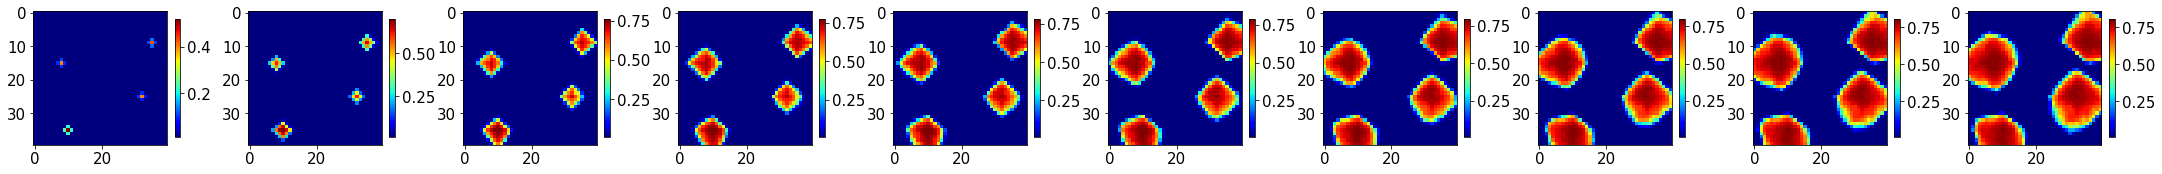

In [31]:
for k in [60, 87]:
    plt.figure(figsize=(30, 5))
    for t in range(10):
        plt.subplot(1, 10, t + 1)
        plt.imshow(sat_true[k, t, -1, :, :])
        plt.colorbar(fraction = 0.04)
        plt.tight_layout()

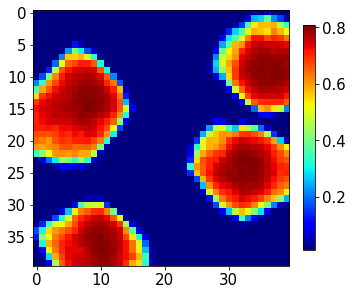

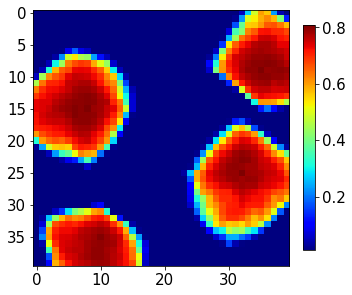

In [32]:
for k in [60, 87]:
    plt.figure(figsize=(5, 5))
 
    plt.imshow(sat_true[k, -1, -1, :, :])
    plt.colorbar(fraction = 0.04)
    plt.tight_layout()

In [16]:

nx, ny, nz = 40, 40, 12
from mpl_toolkits.mplot3d import Axes3D 
voxels = np.ones((nx,ny,nz))
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)

# visualize top layers

In [ ]:
hr = h5py.File('to_visualize_sat_10steps_p5_p95.h5', 'w')
hr.create_dataset('sat_pred', data = sat_pred[picked_case, ...])
hr.create_dataset('sat_true', data = sat_true[picked_case, ...])
hr.close()

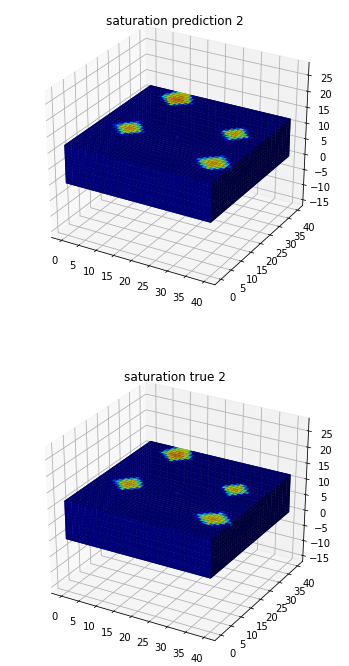

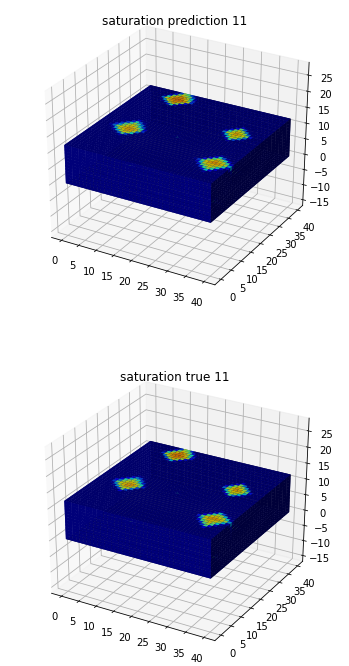

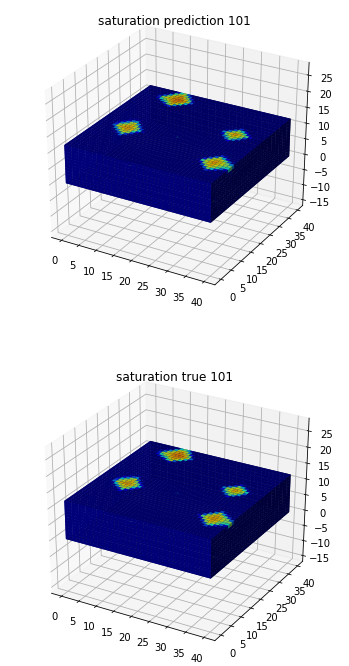

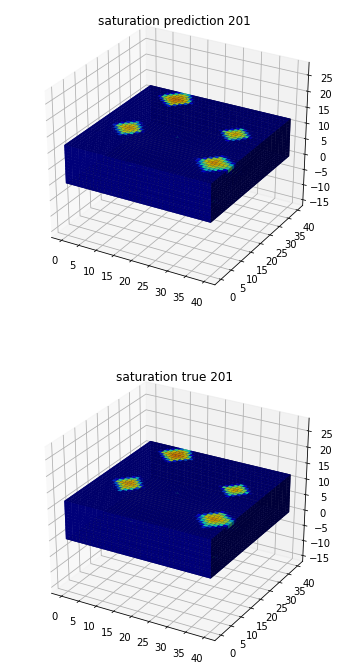

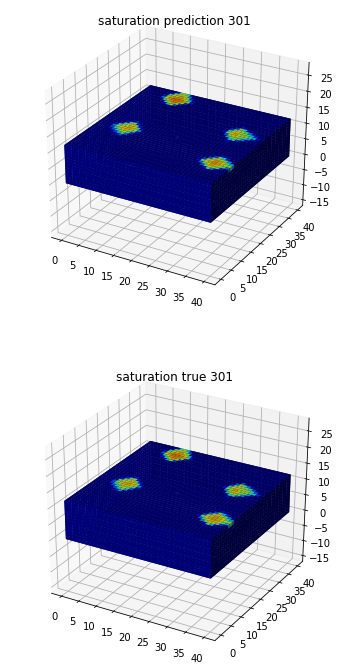

In [17]:
i_tstep = 2
for k in [1, 10, 100, 200, 300]:
    fig = plt.figure(figsize=(6, 12))
    ax = fig.add_subplot(2, 1, 1, projection='3d')
    data = sat_pred[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = data[:, :, ::-1]
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("saturation prediction %d" % (k+1))
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    data = sat_true[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = data[:, :, ::-1]
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("saturation true %d" % (k+1))
    plt.show()

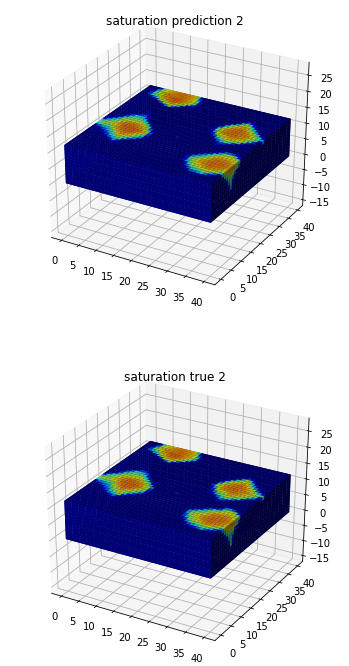

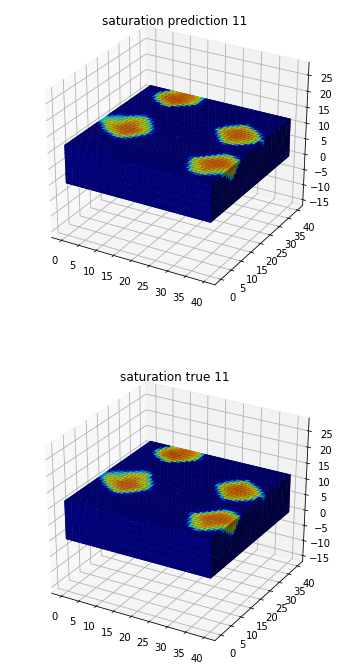

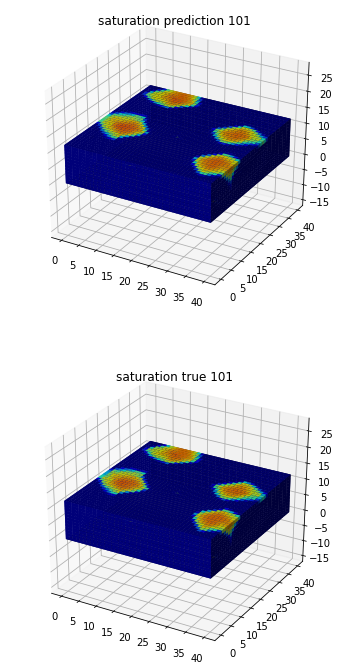

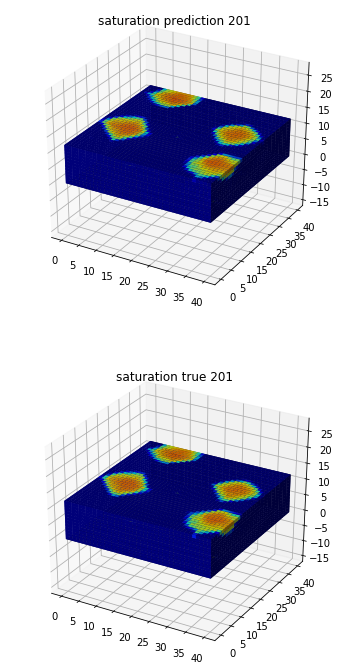

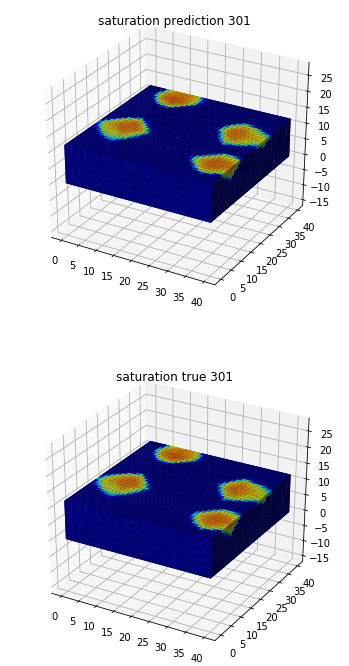

In [18]:
i_tstep = 5
for k in [1, 10, 100, 200, 300]:
    fig = plt.figure(figsize=(6, 12))
    ax = fig.add_subplot(2, 1, 1, projection='3d')
    data = sat_pred[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = data[:, :, ::-1]
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("saturation prediction %d" % (k+1))
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    data = sat_true[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = data[:, :, ::-1]
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("saturation true %d" % (k+1))
    plt.show()

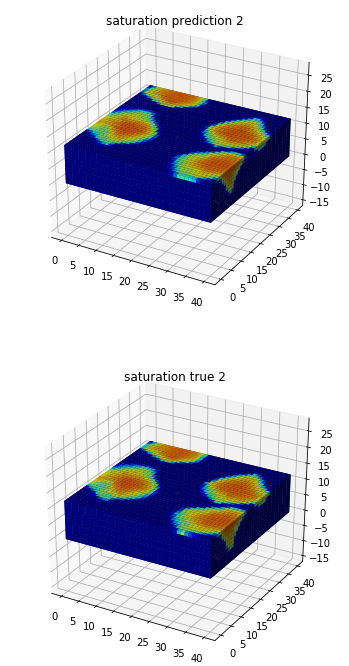

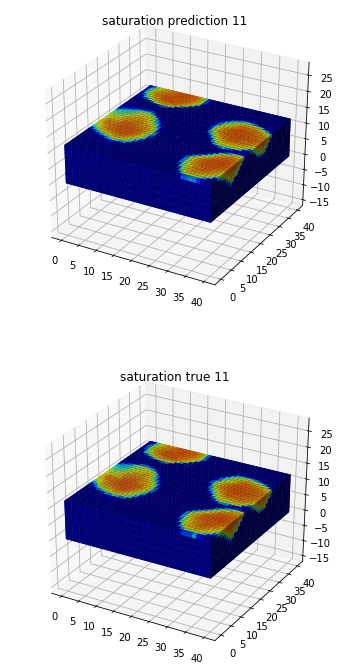

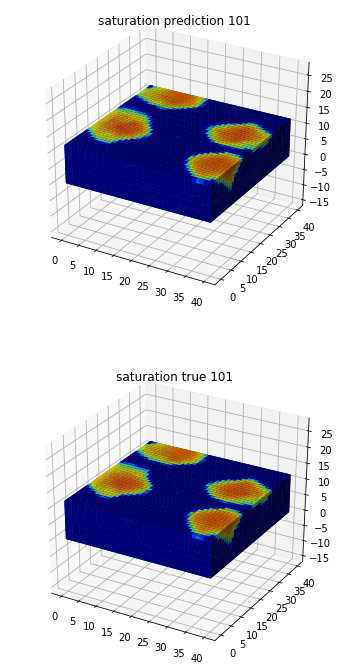

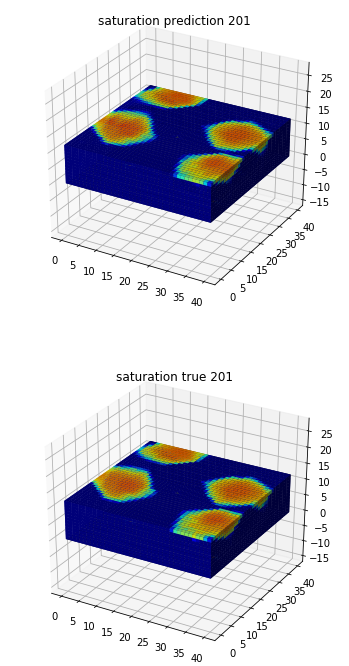

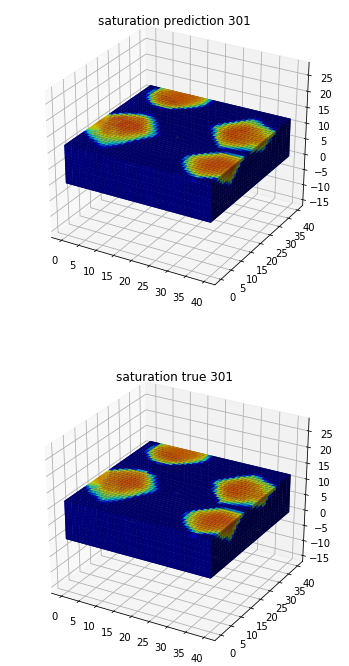

In [19]:
i_tstep = -1
for k in [1, 10, 100, 200, 300]:
    fig = plt.figure(figsize=(6, 12))
    ax = fig.add_subplot(2, 1, 1, projection='3d')
    data = sat_pred[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = data[:, :, ::-1]
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("saturation prediction %d" % (k+1))
    ax = fig.add_subplot(2, 1, 2, projection='3d')
    data = sat_true[k, i_tstep, ::-1, :, :].transpose((2,1,0))
    data = data[:, :, ::-1]
    colors = plt.cm.jet(data)
    ax.auto_scale_xyz([0, nx], [0, ny], [0, nz])
    axisEqual3D(ax)
    ax.voxels(voxels, facecolors=colors, edgecolor=None)
    plt.title("saturation true %d" % (k+1))
    plt.show()

## compute relative error

In [20]:
sat_pred.shape

(500, 10, 12, 40, 40)

In [21]:
sat_pred.min()

-0.098237455

In [22]:
sat_pred.max()

0.8677346

In [23]:
sat_pred[sat_pred < 0.01] = 0.01


In [42]:
error_in_time = np.mean( (np.abs(sat_pred[-50:, ...] - sat_true[-50:, ...])) / (sat_true[-50:, ...] + 0.01), axis = (0, 2, 3, 4))

In [43]:
error_in_time

array([0.03309531, 0.0375121 , 0.04449398, 0.04784484, 0.05024209,
       0.05333466, 0.05639781, 0.05944005, 0.06270664, 0.09010071])

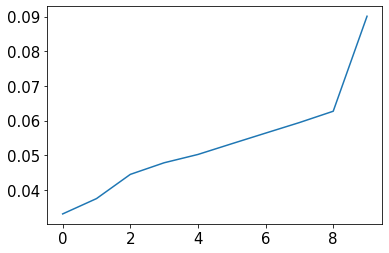

In [44]:
plt.figure()
plt.plot(error_in_time)
plt.show()

In [45]:
np.mean(error_in_time)

0.05351681696980376

In [34]:
picked_case = list(range(10))

In [28]:
hr = h5py.File('sat_pred_10steps_bs4_hd0_lr3e-4_filter_16_32_32_64.h5', 'w')
hr.create_dataset('sat_pred', data = sat_pred)
hr.create_dataset('sat_true', data = sat_true)
hr.close()

In [29]:
picked_case = [0, 1, 100, 200, 300]

In [32]:
hr.close()

In [35]:
hr = h5py.File('to_visualize_sat_pred_true_10steps.h5', 'w')
hr.create_dataset('sat_pred', data = sat_pred[picked_case, ...])
hr.create_dataset('sat_true', data = sat_true[picked_case, ...])
hr.close()